In [27]:
# coding: utf8
#!/usr/bin/env python
# ------------------------------------------------------------------------
# Carte de Kohonen
# Écrit par Mathieu Lefort
#
# Distribué sous licence BSD.
# ------------------------------------------------------------------------
# Implémentation de l'algorithme des cartes auto-organisatrices de Kohonen
# ------------------------------------------------------------------------
# Pour que les divisions soient toutes réelles (pas de division entière)
from __future__ import division
# Librairie de calcul matriciel
import numpy
# Librairie d'affichage
import matplotlib.pyplot as plt
import os

In [28]:
class Neuron:
  ''' Classe représentant un neurone '''
  
  def __init__(self, w, posx, posy):
    '''
    @summary: Création d'un neurone
    @param w: poids du neurone
    @type w: numpy array
    @param posx: position en x du neurone dans la carte
    @type posx: int
    @param posy: position en y du neurone dans la carte
    @type posy: int
    '''
    # Initialisation des poids
    self.weights = w.flatten()
    # Initialisation de la position
    self.posx = posx
    self.posy = posy
    # Initialisation de la sortie du neurone
    self.y = 0.
  
  def compute(self,x):
    '''
    @summary: Affecte à y la valeur de sortie du neurone (ici on choisit la distance entre son poids et l'entrée, i.e. une fonction d'aggrégation identité)
    @param x: entrée du neurone
    @type x: numpy array
    '''
    # On calcule la distance entre le poids du neurone et l'entrée
    self.y = numpy.linalg.norm(self.weights - x.flatten())

  def learn(self,eta,sigma,posxjetoile,posyjetoile,x):
    '''
    @summary: Modifie les poids selon la règle de Kohonen
    @param eta: taux d'apprentissage
    @type eta: float
    @param sigma: largeur du voisinage
    @type sigma: float
    @param posxjetoile: position en x du neurone gagnant (i.e. celui dont le poids est le plus proche de l'entrée)
    @type posxjetoile: int
    @param posyjetoile: position en y du neurone gagnant (i.e. celui dont le poids est le plus proche de l'entrée)
    @type posyjetoile: int
    @param x: entrée du neurone
    @type x: numpy array
    '''
    # Calcul de la distance entre le neurone et le neurone gagnant
    dist = (self.posx - posxjetoile)**2 + (self.posy - posyjetoile)**2
    h = numpy.exp(-dist / (2 * sigma * sigma))
    self.weights[:] = self.weights[:] + eta * h * (x.flatten() - self.weights)

In [29]:
class SOM:
  ''' Classe implémentant une carte de Kohonen. '''

  def __init__(self, inputsize, gridsize):
    '''
    @summary: Création du réseau
    @param inputsize: taille de l'entrée
    @type inputsize: tuple
    @param gridsize: taille de la carte
    @type gridsize: tuple
    '''
    # Initialisation de la taille de l'entrée
    self.inputsize = inputsize
    # Initialisation de la taille de la carte
    self.gridsize = gridsize
    # Création de la carte
    # Carte de neurones
    self.map = []    
    # Carte des poids
    self.weightsmap = []
    # Carte des activités
    self.activitymap = []
    for posx in range(gridsize[0]):
      mline = []
      wmline = []
      amline = []
      for posy in range(gridsize[1]):
        neuron = Neuron(numpy.random.random(self.inputsize),posx,posy)
        mline.append(neuron)
        wmline.append(neuron.weights)
        amline.append(neuron.y)
      self.map.append(mline)
      self.weightsmap.append(wmline)
      self.activitymap.append(amline)
    self.activitymap = numpy.array(self.activitymap)

  def compute(self,x):
    '''
    @summary: calcule de l'activité des neurones de la carte
    @param x: entrée de la carte (identique pour chaque neurone)
    @type x: numpy array
    '''
    # On demande à chaque neurone de calculer son activité et on met à jour la carte d'activité de la carte
    for posx in range(self.gridsize[0]):
      for posy in range(self.gridsize[1]):
        self.map[posx][posy].compute(x)
        self.activitymap[posx][posy] = self.map[posx][posy].y

  def learn(self,eta,sigma,x):
    '''
    @summary: Modifie les poids de la carte selon la règle de Kohonen
    @param eta: taux d'apprentissage
    @type eta: float
    @param sigma: largeur du voisinage
    @type sigma: float
    @param x: entrée de la carte
    @type x: numpy array
    '''
    # Calcul du neurone vainqueur
    jetoilex,jetoiley = numpy.unravel_index(numpy.argmin(self.activitymap),self.gridsize)
    # Mise à jour des poids de chaque neurone
    for posx in range(self.gridsize[0]):
      for posy in range(self.gridsize[1]):
        self.map[posx][posy].learn(eta,sigma,jetoilex,jetoiley,x)

        
      

  def scatter_plot(self,interactive=False):
    '''
    @summary: Affichage du réseau dans l'espace d'entrée (utilisable dans le cas d'entrée à deux dimensions et d'une carte avec une topologie de grille carrée)
    @param interactive: Indique si l'affichage se fait en mode interactif
    @type interactive: boolean
    '''
    # Création de la figure
    if not interactive:
      plt.figure()
    # Récupération des poids
    w = numpy.array(self.weightsmap)
    # Affichage des poids
    plt.scatter(w[:,:,0].flatten(),w[:,:,1].flatten(),c='k')
    # Affichage de la grille
    for i in range(w.shape[0]):
      plt.plot(w[i,:,0],w[i,:,1],'k',linewidth=1.)
    for i in range(w.shape[1]):
      plt.plot(w[:,i,0],w[:,i,1],'k',linewidth=1.)
    # Modification des limites de l'affichage
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    # Affichage du titre de la figure
    plt.suptitle('Poids dans l\'espace d\'entree')
    # Affichage de la figure
    if not interactive:
      plt.show()

  def scatter_plot_2(self,interactive=False):
    '''
    @summary: Affichage du réseau dans l'espace d'entrée en 2 fois 2d (utilisable dans le cas d'entrée à quatre dimensions et d'une carte avec une topologie de grille carrée)
    @param interactive: Indique si l'affichage se fait en mode interactif
    @type interactive: boolean
    '''
    # Création de la figure
    if not interactive:
      plt.figure()
    # Affichage des 2 premières dimensions dans le plan
    plt.subplot(1,2,1)
    # Récupération des poids
    w = numpy.array(self.weightsmap)
    # Affichage des poids
    plt.scatter(w[:,:,0].flatten(),w[:,:,1].flatten(),c='k')
    # Affichage de la grille
    for i in range(w.shape[0]):
      plt.plot(w[i,:,0],w[i,:,1],'k',linewidth=1.)
    for i in range(w.shape[1]):
      plt.plot(w[:,i,0],w[:,i,1],'k',linewidth=1.)
    # Affichage des 2 dernières dimensions dans le plan
    plt.subplot(1,2,2)
    # Récupération des poids
    w = numpy.array(self.weightsmap)
    # Affichage des poids
    plt.scatter(w[:,:,2].flatten(),w[:,:,3].flatten(),c='k')
    # Affichage de la grille
    for i in range(w.shape[0]):
      plt.plot(w[i,:,2],w[i,:,3],'k',linewidth=1.)
    for i in range(w.shape[1]):
      plt.plot(w[:,i,2],w[:,i,3],'k',linewidth=1.)
    # Affichage du titre de la figure
    plt.suptitle('Poids dans l\'espace d\'entree')
    # Affichage de la figure
    if not interactive:
      plt.show()

  def plot(self):
    '''
    @summary: Affichage des poids du réseau (matrice des poids)
    '''
    # Récupération des poids
    w = numpy.array(self.weightsmap)
    # Création de la figure
    f,a = plt.subplots(w.shape[0],w.shape[1])    
    # Affichage des poids dans un sous graphique (suivant sa position de la SOM)
    for i in range(w.shape[0]):
      for j in range(w.shape[1]):
        plt.subplot(w.shape[0],w.shape[1],i*w.shape[1]+j+1)
        im = plt.imshow(w[i,j].reshape(self.inputsize),interpolation='nearest',vmin=numpy.min(w),vmax=numpy.max(w),cmap='binary')
        plt.xticks([])
        plt.yticks([])
    # Affichage de l'échelle
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    f.colorbar(im, cax=cbar_ax)
    # Affichage du titre de la figure
    plt.suptitle('Poids dans l\'espace de la carte')
    # Affichage de la figure
    plt.show()

  def quantification(self,X):
    '''
    @summary: Calcul de l'erreur de quantification vectorielle moyenne du réseau sur le jeu de données
    @param X: le jeu de données
    @type X: numpy array
    '''
    # On récupère le nombre d'exemples
    nsamples = X.shape[0]
    # Somme des erreurs quadratiques
    s = 0
    # Pour tous les exemples du jeu de test
    for x in X:
      # On calcule la distance à chaque poids de neurone
      self.compute(x.flatten())
      # On rajoute la distance minimale au carré à la somme
      s += numpy.min(self.activitymap)**2
    # On renvoie l'erreur de quantification vectorielle moyenne
    return s/nsamples

def distorsion_locale_moyenne(network):
    '''
    @summary: Calcule la distorsion locale moyenne entre neurones voisins
    @param network: une instance de SOM
    @return: valeur moyenne des distances entre les poids de neurones voisins
    '''
    w = numpy.array(network.weightsmap)
    total = 0
    count = 0
    for i in range(network.gridsize[0]):
        for j in range(network.gridsize[1]):
            current = w[i][j]
            # voisins droite et bas (pour éviter double comptage)
            if i + 1 < network.gridsize[0]:
                total += numpy.linalg.norm(current - w[i+1][j])**2
                count += 1
            if j + 1 < network.gridsize[1]:
                total += numpy.linalg.norm(current - w[i][j+1])**2
                count += 1
    return total / count

def compute_local_roughness(weight_grid):
    """
    Calcule la rugosité locale moyenne de la carte de poids.
    
    Paramètre :
        weight_grid (np.ndarray) : un tableau numpy de forme (height, width, dim),
                                   contenant les vecteurs de poids de chaque neurone.
        
    Retour :
        float : la rugosité moyenne de la carte.
    """
    height, width, dim = weight_grid.shape
    total_roughness = 0
    count = 0

    # Parcours de chaque neurone
    for i in range(height):
        for j in range(width):
            w_ij = weight_grid[i, j]
            neighbors = []

            # Voisins 4-connectés (haut, bas, gauche, droite)
            if i > 0: neighbors.append(weight_grid[i - 1, j])
            if i < height - 1: neighbors.append(weight_grid[i + 1, j])
            if j > 0: neighbors.append(weight_grid[i, j - 1])
            if j < width - 1: neighbors.append(weight_grid[i, j + 1])

            # Calcul des distances aux voisins
            for w_neighbor in neighbors:
                dist_sq = numpy.linalg.norm(w_ij - w_neighbor)**2
                total_roughness += dist_sq
                count += 1

    return total_roughness / count if count > 0 else 0


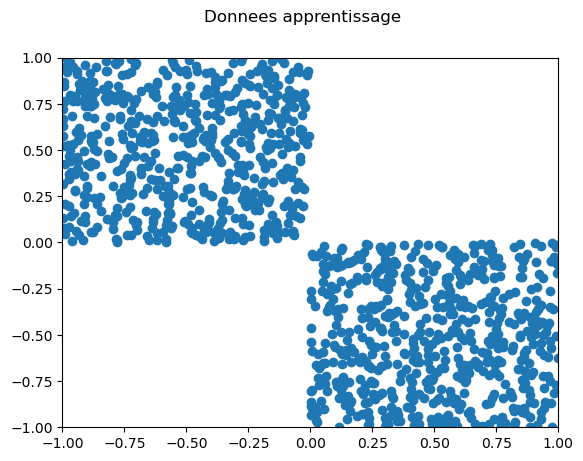

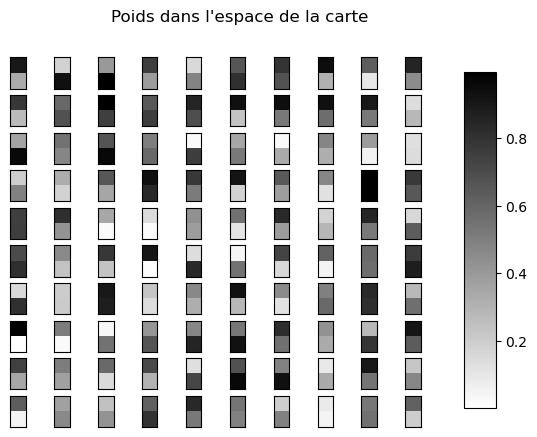

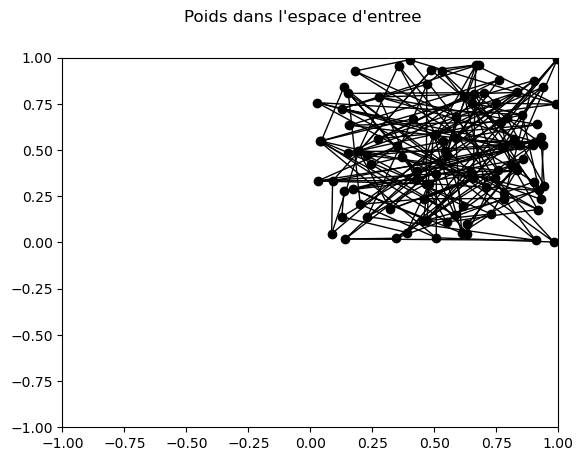

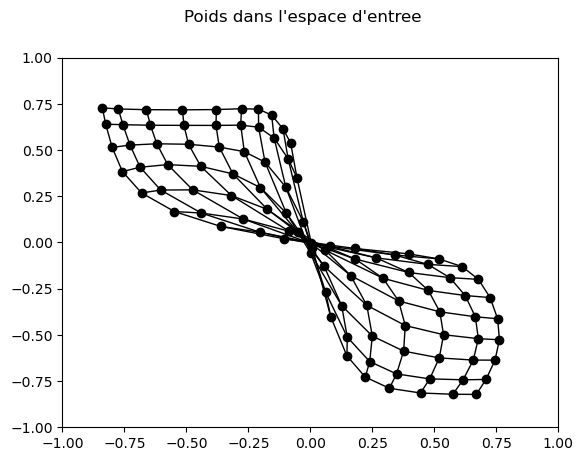

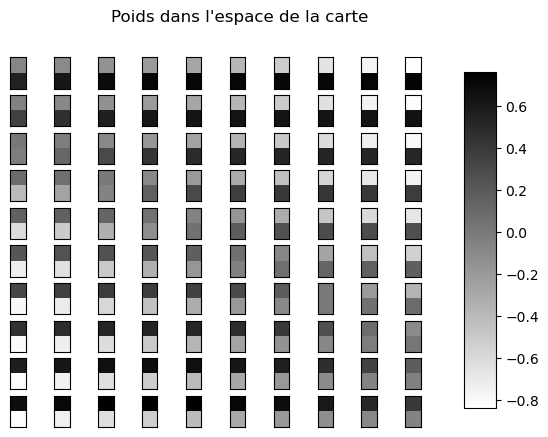

erreur de quantification vectorielle moyenne  0.01564400368180778
distorsion locale moyenne  0.030813220475244464
rugosite locale moyenne  0.03081322047524446


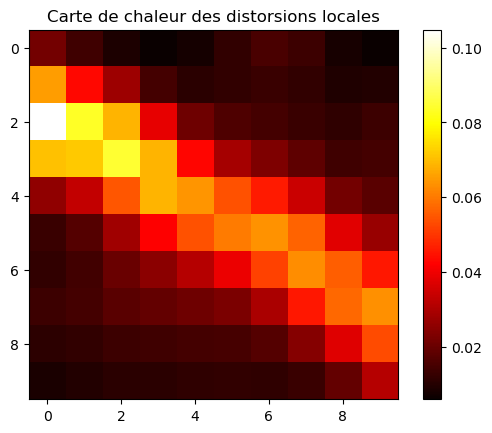

In [30]:

# -----------------------------------------------------------------------------
if __name__ == '__main__':
  # Création d'un réseau avec une entrée (2,1) et une carte (10,10)
  #TODO mettre à jour la taille des données d'entrée pour les données robotiques
  network = SOM((2,1),(10,10))
  # PARAMÈTRES DU RÉSEAU
  # Taux d'apprentissage
  ETA = 0.05
  # Largeur du voisinage
  SIGMA = 1.4
  # Nombre de pas de temps d'apprentissage
  N = 30000
  # Affichage interactif de l'évolution du réseau 
  #TODO à mettre à faux pour que les simulations aillent plus vite
  VERBOSE = False
  # Nombre de pas de temps avant rafraissichement de l'affichage
  NAFFICHAGE = 1000
  # DONNÉES D'APPRENTISSAGE
  # Nombre de données à générer pour les ensembles 1, 2 et 3
  # TODO décommenter les données souhaitées
  nsamples = 1200
  # Ensemble de données 1
#  samples = numpy.random.random((nsamples,2,1))*2-1
  # Ensemble de données 2
#  samples1 = -numpy.random.random((nsamples//3,2,1))
#  samples2 = numpy.random.random((nsamples//3,2,1))
#  samples2[:,0,:] -= 1
#  samples3 = numpy.random.random((nsamples//3,2,1))
#  samples3[:,1,:] -= 1
#  samples = numpy.concatenate((samples1,samples2,samples3))
  # Ensemble de données 3
#  samples1 = numpy.random.random((nsamples//2,2,1))
#  samples1[:,0,:] -= 1
#  samples2 = numpy.random.random((nsamples//2,2,1))
#  samples2[:,1,:] -= 1
#  samples = numpy.concatenate((samples1,samples2))
  # Ensemble de données robotiques
#  samples = numpy.random.random((nsamples,4,1))
#  samples[:,0:2,:] *= numpy.pi
#  l1 = 0.7
#  l2 = 0.3
#  samples[:,2,:] = l1*numpy.cos(samples[:,0,:])+l2*numpy.cos(samples[:,0,:]+samples[:,1,:])
#  samples[:,3,:] = l1*numpy.sin(samples[:,0,:])+l2*numpy.sin(samples[:,0,:]+samples[:,1,:])
  # Affichage des données (pour les ensembles 1, 2 et 3)
  plt.figure()
  plt.scatter(samples[:,0,0], samples[:,1,0])
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.suptitle('Donnees apprentissage')
  plt.show()

  dossier = "ETA = " + str(ETA) + " SIGMA = " + str(SIGMA) + " N = " + str(N) + "NAFFICHAGE = " + str(NAFFICHAGE)
  path = os.path.join(r"C:\Users\amaur\Documents\Amaury Polytech\Semestre 8\ia\TP_1\Tests", dossier)
  if not os.path.exists(path):
      os.makedirs(path)
  # Affichage des données (pour l'ensemble robotique)
#  plt.figure()
#  plt.subplot(1,2,1)
#  plt.scatter(samples[:,0,0].flatten(),samples[:,1,0].flatten(),c='k')
#  plt.subplot(1,2,2)
#  plt.scatter(samples[:,2,0].flatten(),samples[:,3,0].flatten(),c='k')
#  plt.suptitle('Donnees apprentissage')
#  plt.show()
    
  # SIMULATION
  # Affichage des poids du réseau
  network.plot()
  # Initialisation de l'affichage interactif
  if VERBOSE:
    # Création d'une figure
    plt.figure()
    # Mode interactif
    plt.ion()
    # Affichage de la figure
    plt.show()
  else:
  	# Affichage de la grille initiale
  	network.scatter_plot(False)
  # Boucle d'apprentissage
  for i in range(N+1):
    # Choix d'un exemple aléatoire pour l'entrée courante
    index = numpy.random.randint(nsamples)
    x = samples[index].flatten()
    # Calcul de l'activité du réseau
    network.compute(x)
    # Modification des poids du réseau
    network.learn(ETA,SIGMA,x)
    # Mise à jour de l'affichage
    if VERBOSE and i%NAFFICHAGE==0:
      # Effacement du contenu de la figure
      plt.clf()
      # Remplissage de la figure
      # TODO à remplacer par scatter_plot_2 pour les données robotiques
      network.scatter_plot(True)
      # Affichage du contenu de la figure
      plt.pause(0.00001)
      plt.draw()
  # Fin de l'affichage interactif
  if VERBOSE:
    # Désactivation du mode interactif
    plt.ioff()
  else:
  	# Affichage de la grille finale
  	network.scatter_plot(False)
  # Affichage des poids du réseau
  network.plot()
  # Affichage de l'erreur de quantification vectorielle moyenne après apprentissage
  print("erreur de quantification vectorielle moyenne ",network.quantification(samples))
  print("distorsion locale moyenne ",distorsion_locale_moyenne(network))
  print("rugosite locale moyenne ",compute_local_roughness(numpy.array(network.weightsmap)))

def carte_de_chaleur_distorsion(network):
    '''
    @summary: Affiche une carte de chaleur des différences locales entre poids de neurones voisins
    '''
    w = numpy.array(network.weightsmap)
    heatmap = numpy.zeros((network.gridsize[0], network.gridsize[1]))
    for i in range(network.gridsize[0]):
        for j in range(network.gridsize[1]):
            dist = 0
            count = 0
            if i > 0:
                dist += numpy.linalg.norm(w[i][j] - w[i-1][j])**2
                count += 1
            if i < network.gridsize[0] - 1:
                dist += numpy.linalg.norm(w[i][j] - w[i+1][j])**2
                count += 1
            if j > 0:
                dist += numpy.linalg.norm(w[i][j] - w[i][j-1])**2
                count += 1
            if j < network.gridsize[1] - 1:
                dist += numpy.linalg.norm(w[i][j] - w[i][j+1])**2
                count += 1
            heatmap[i][j] = dist / count if count > 0 else 0
    plt.figure()
    plt.imshow(heatmap, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title("Carte de chaleur des distorsions locales")
    plt.show()







carte_de_chaleur_distorsion(network)


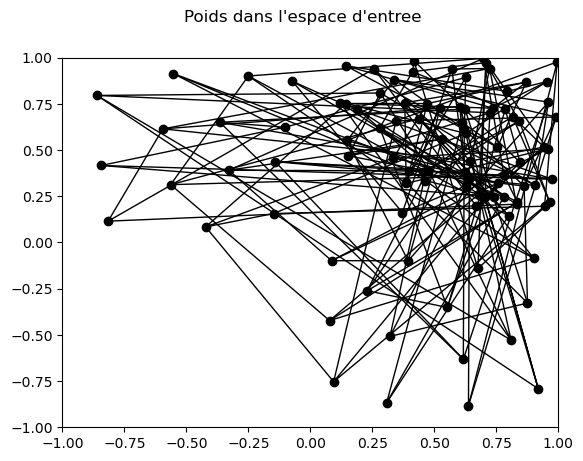

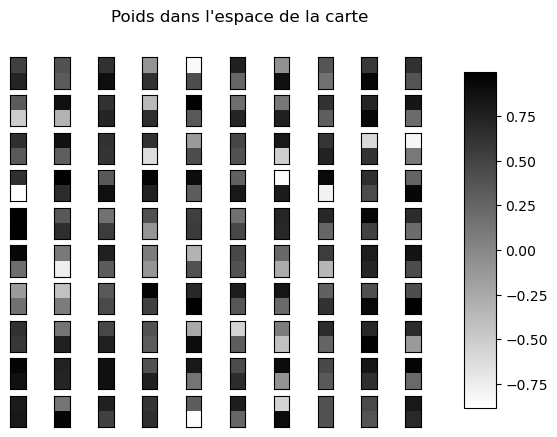

Sigma: 0.1
Erreur de quantification vectorielle moyenne: 0.01141447846421632
Distorsion locale moyenne: 0.7716564624159332
Rugosité locale moyenne: 0.7716564624159343


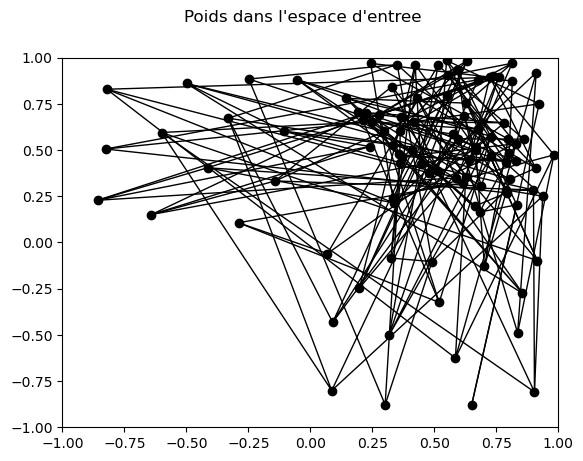

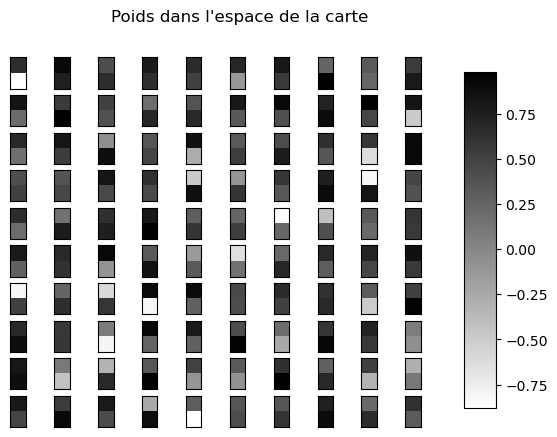

Sigma: 0.2
Erreur de quantification vectorielle moyenne: 0.011828388679533968
Distorsion locale moyenne: 0.7712613406722498
Rugosité locale moyenne: 0.7712613406722492


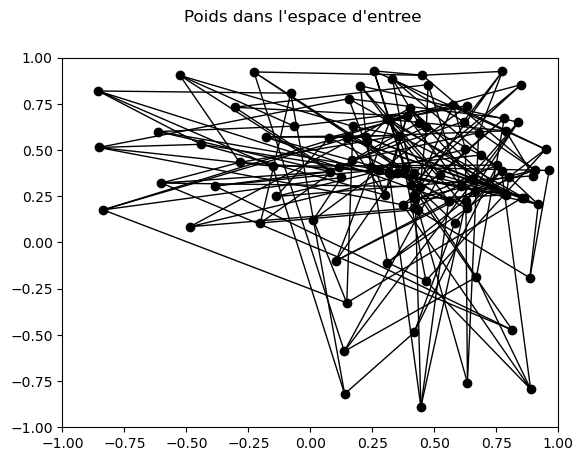

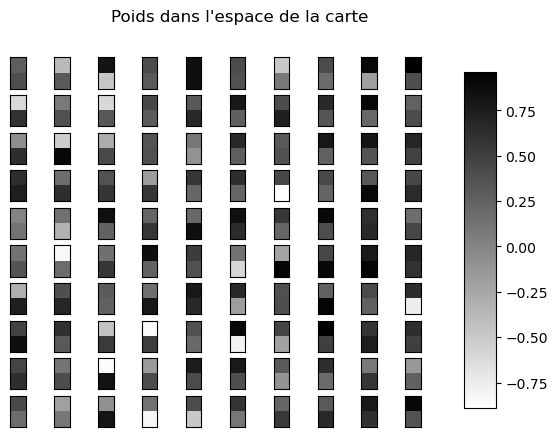

Sigma: 0.30000000000000004
Erreur de quantification vectorielle moyenne: 0.0114731469215919
Distorsion locale moyenne: 0.5151889550720927
Rugosité locale moyenne: 0.5151889550720927


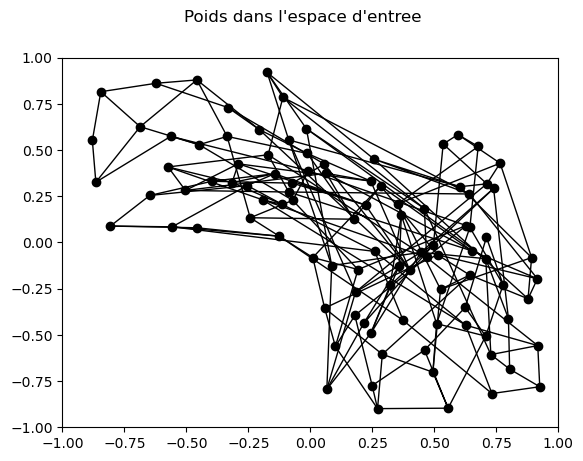

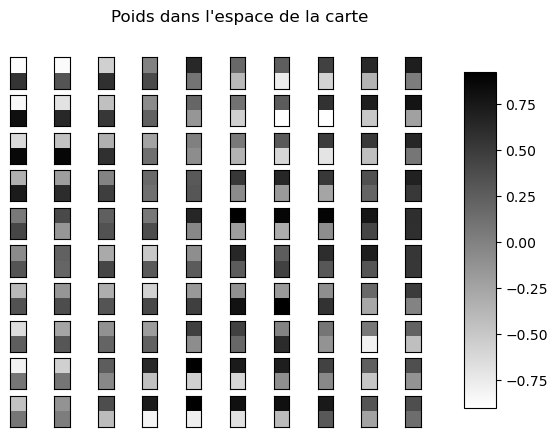

Sigma: 0.4
Erreur de quantification vectorielle moyenne: 0.0056945799833523995
Distorsion locale moyenne: 0.20140017342225908
Rugosité locale moyenne: 0.201400173422259


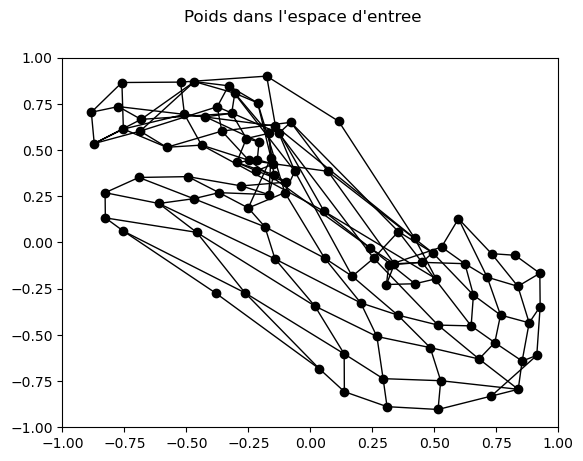

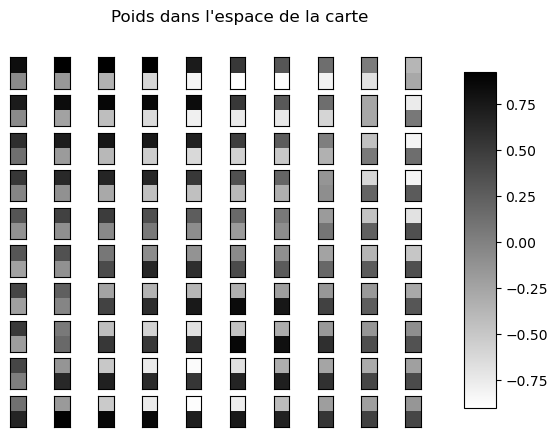

Sigma: 0.5
Erreur de quantification vectorielle moyenne: 0.005417817451737733
Distorsion locale moyenne: 0.0834344864272861
Rugosité locale moyenne: 0.08343448642728611


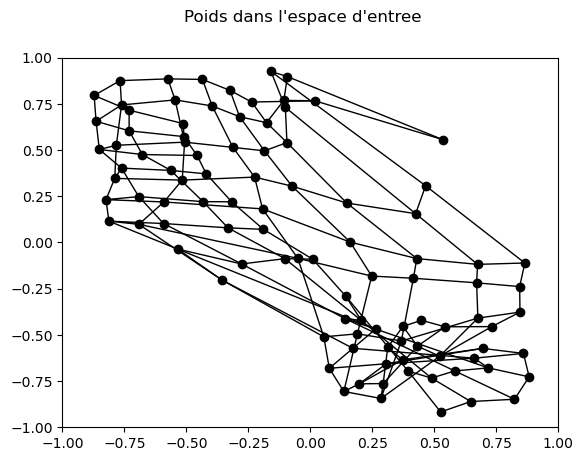

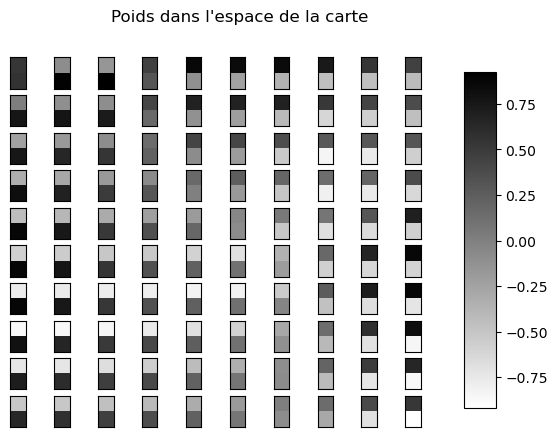

Sigma: 0.6
Erreur de quantification vectorielle moyenne: 0.00543347047939589
Distorsion locale moyenne: 0.07419553204524597
Rugosité locale moyenne: 0.074195532045246


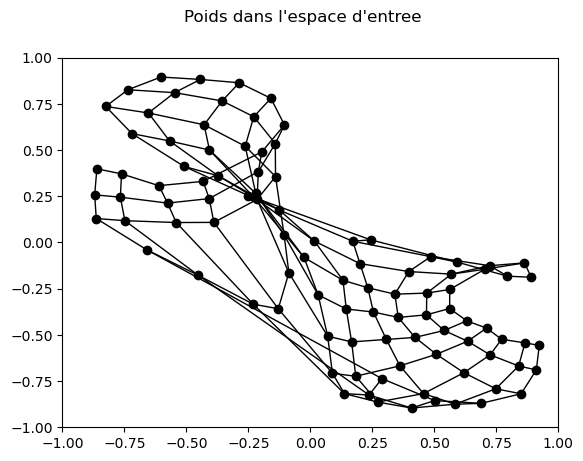

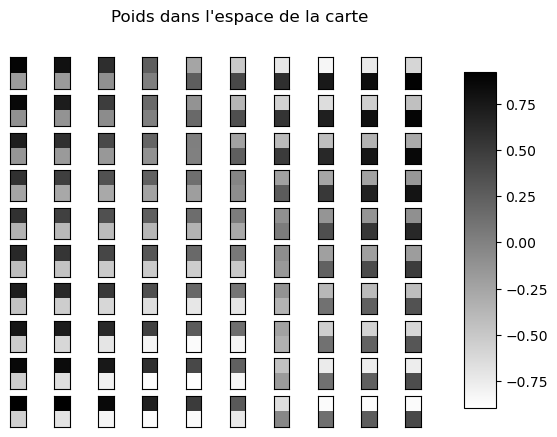

Sigma: 0.7000000000000001
Erreur de quantification vectorielle moyenne: 0.0058371320491678496
Distorsion locale moyenne: 0.053340924306076974
Rugosité locale moyenne: 0.053340924306077016


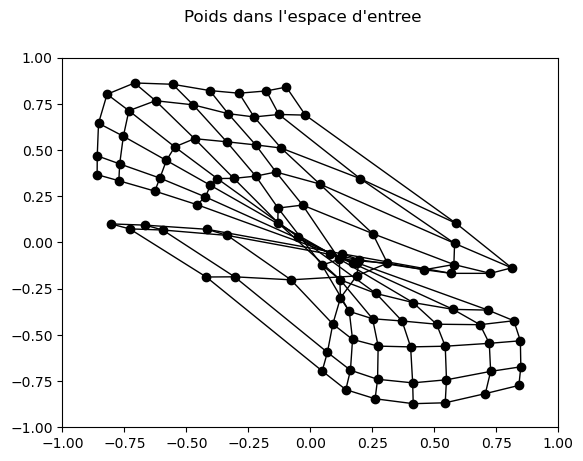

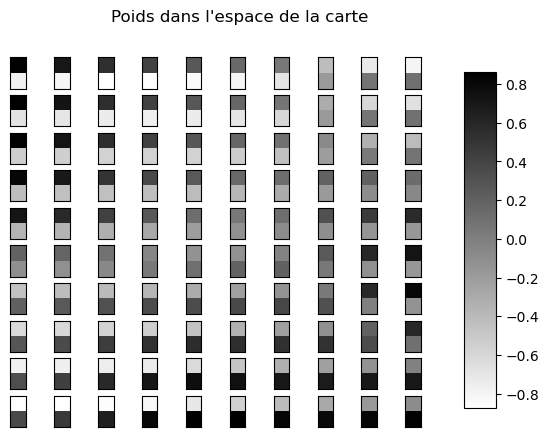

Sigma: 0.8
Erreur de quantification vectorielle moyenne: 0.006326735886701488
Distorsion locale moyenne: 0.06132847678311234
Rugosité locale moyenne: 0.06132847678311231


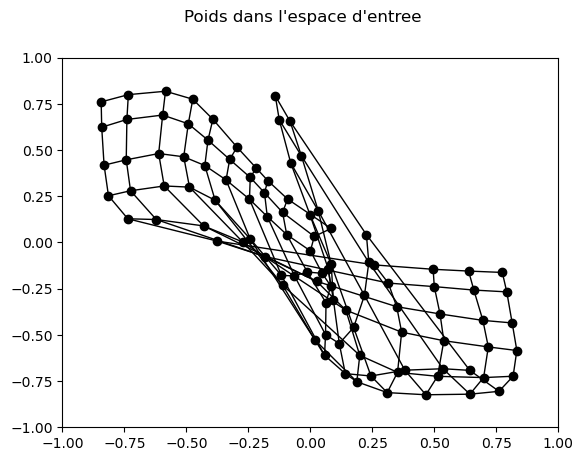

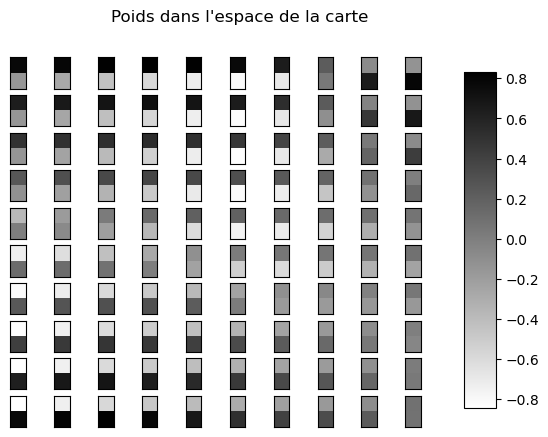

Sigma: 0.9
Erreur de quantification vectorielle moyenne: 0.008661483626306985
Distorsion locale moyenne: 0.0576983027048658
Rugosité locale moyenne: 0.05769830270486589


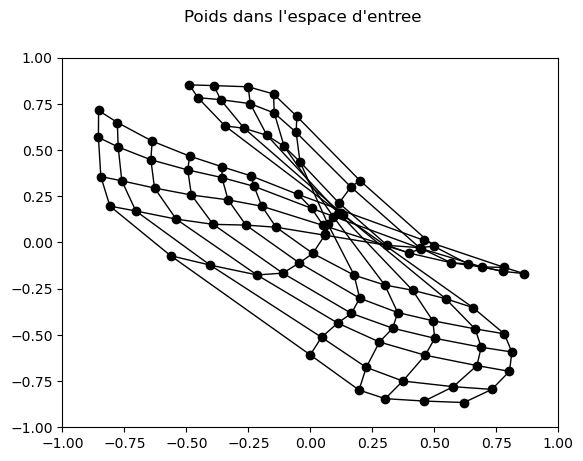

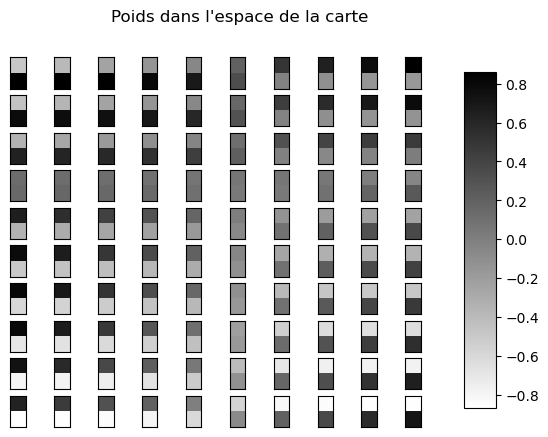

Sigma: 1.0
Erreur de quantification vectorielle moyenne: 0.008606428060477692
Distorsion locale moyenne: 0.05400167492071745
Rugosité locale moyenne: 0.05400167492071741


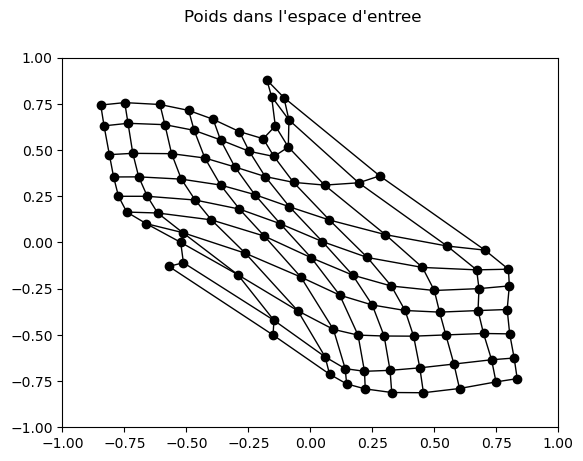

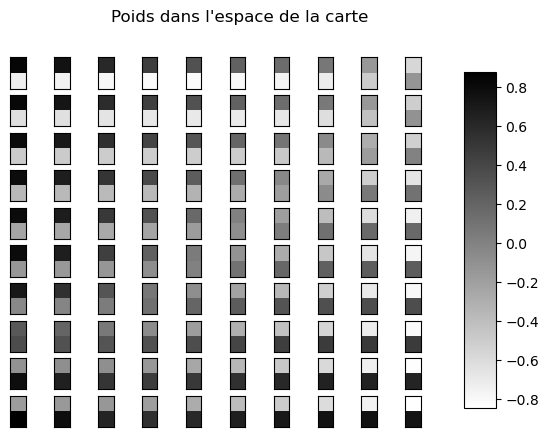

Sigma: 1.1
Erreur de quantification vectorielle moyenne: 0.008740257153054059
Distorsion locale moyenne: 0.036212976858713705
Rugosité locale moyenne: 0.03621297685871377


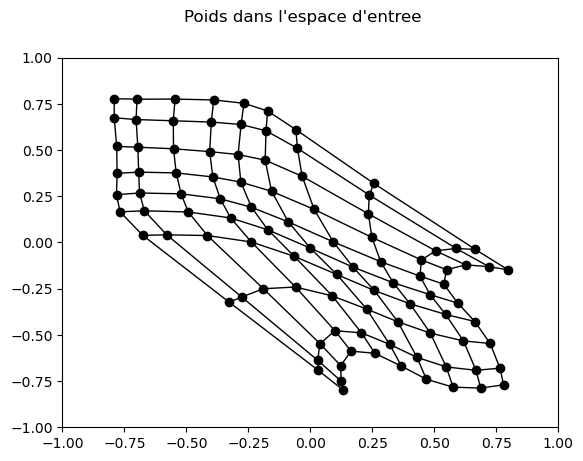

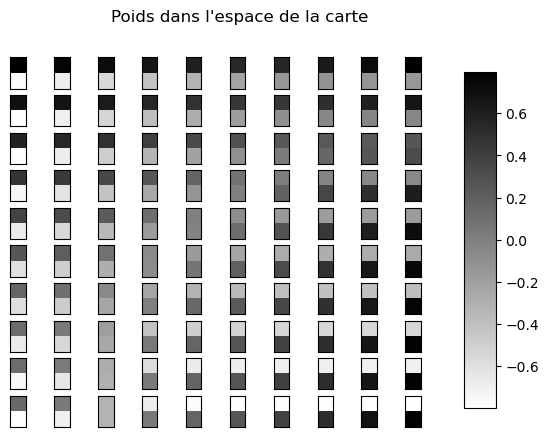

Sigma: 1.2000000000000002
Erreur de quantification vectorielle moyenne: 0.010923585799158551
Distorsion locale moyenne: 0.032507688682384836
Rugosité locale moyenne: 0.032507688682384836


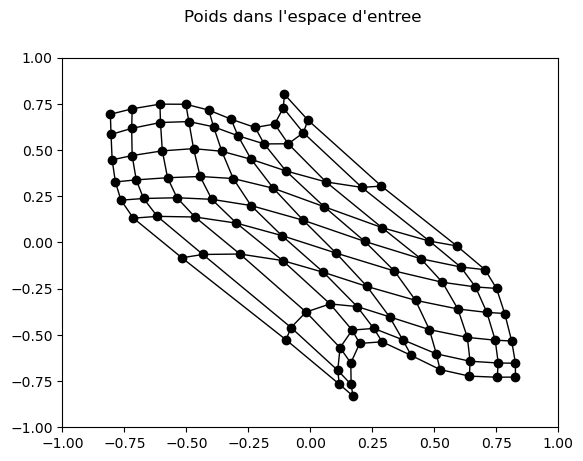

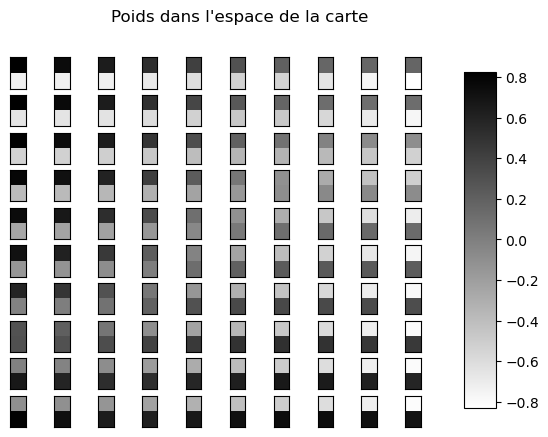

Sigma: 1.3000000000000003
Erreur de quantification vectorielle moyenne: 0.01148469454180404
Distorsion locale moyenne: 0.03200824975062458
Rugosité locale moyenne: 0.032008249750624586


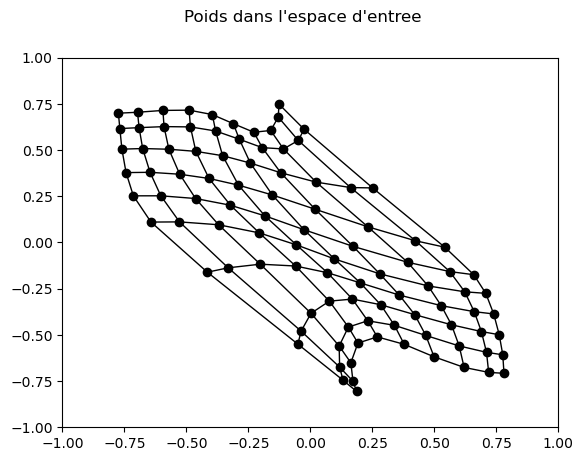

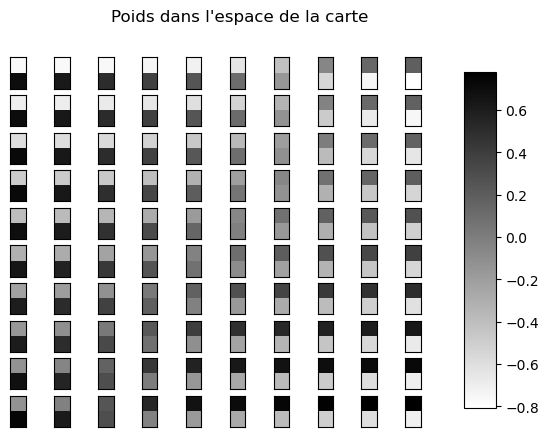

Sigma: 1.4000000000000001
Erreur de quantification vectorielle moyenne: 0.015575315518164165
Distorsion locale moyenne: 0.027741387707243603
Rugosité locale moyenne: 0.027741387707243586


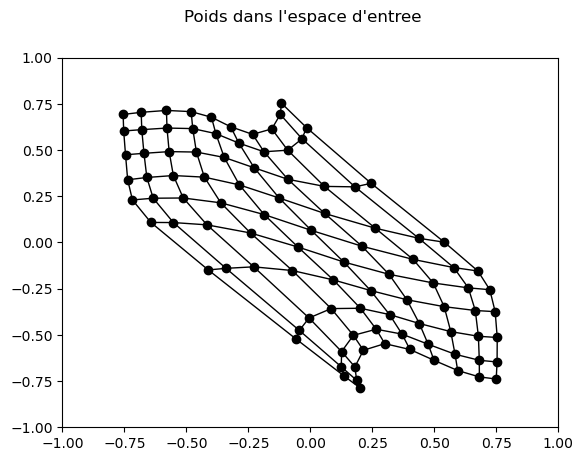

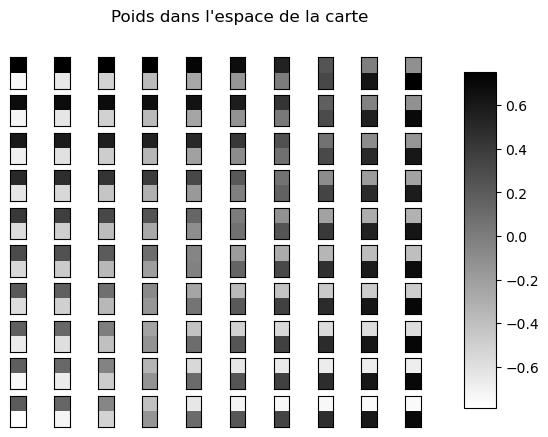

Sigma: 1.5000000000000002
Erreur de quantification vectorielle moyenne: 0.015426290878296839
Distorsion locale moyenne: 0.027900905524825863
Rugosité locale moyenne: 0.02790090552482586


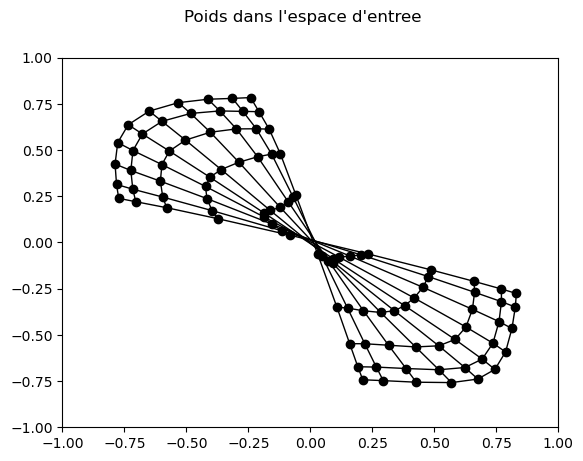

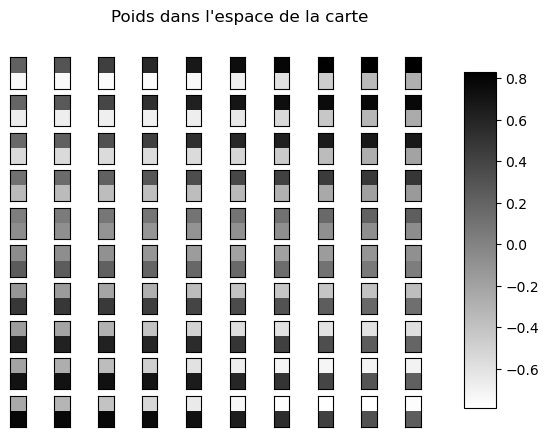

Sigma: 1.6
Erreur de quantification vectorielle moyenne: 0.014877327663556367
Distorsion locale moyenne: 0.02855142685614549
Rugosité locale moyenne: 0.02855142685614544


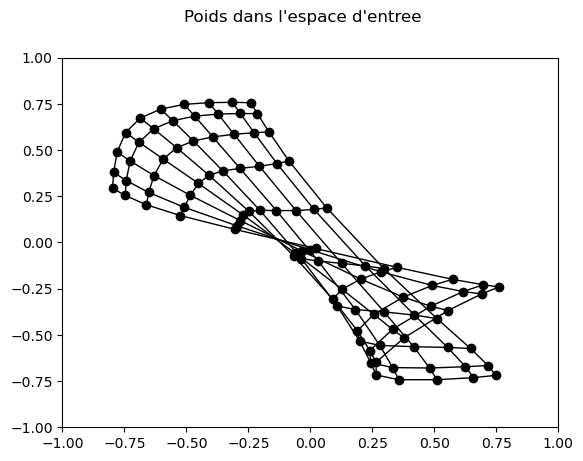

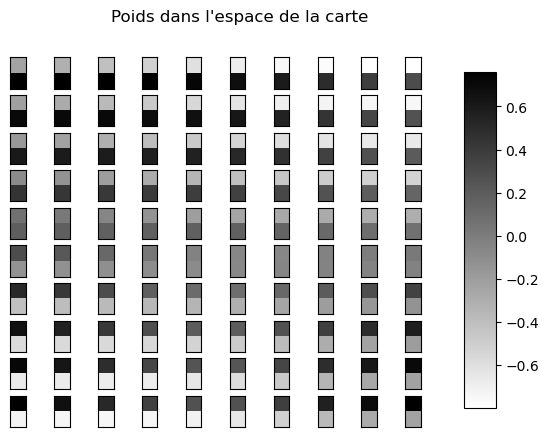

Sigma: 1.7000000000000002
Erreur de quantification vectorielle moyenne: 0.018052877165597014
Distorsion locale moyenne: 0.026589853305875252
Rugosité locale moyenne: 0.026589853305875235


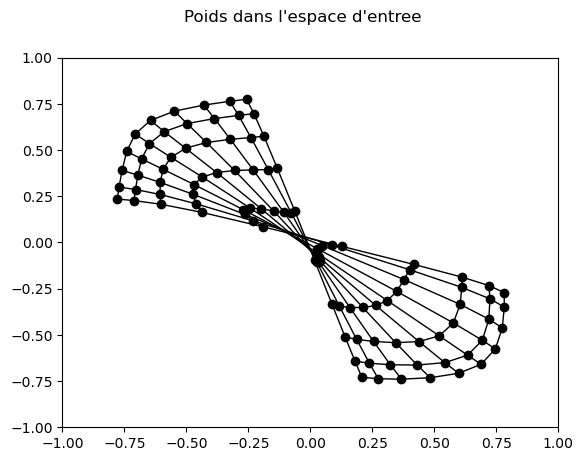

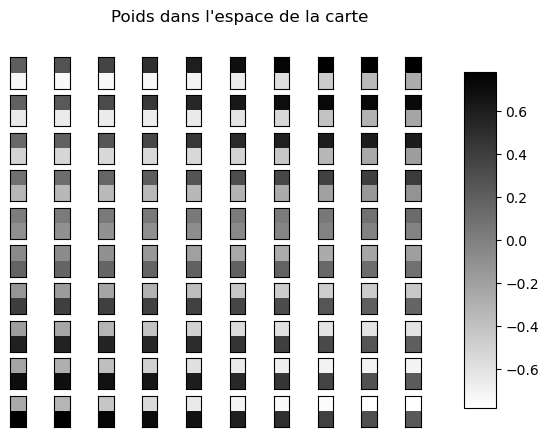

Sigma: 1.8000000000000003
Erreur de quantification vectorielle moyenne: 0.019068329807583464
Distorsion locale moyenne: 0.025919154978348048
Rugosité locale moyenne: 0.025919154978347996


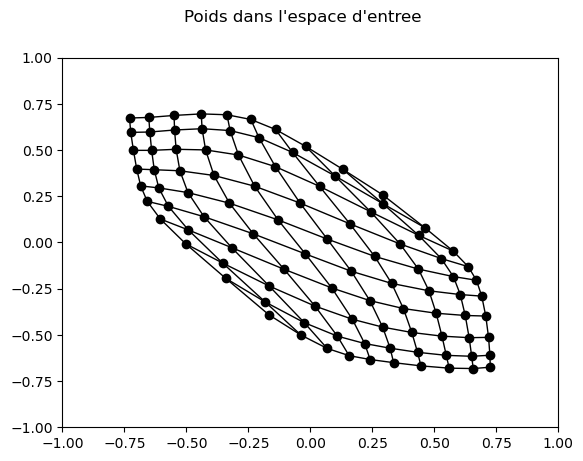

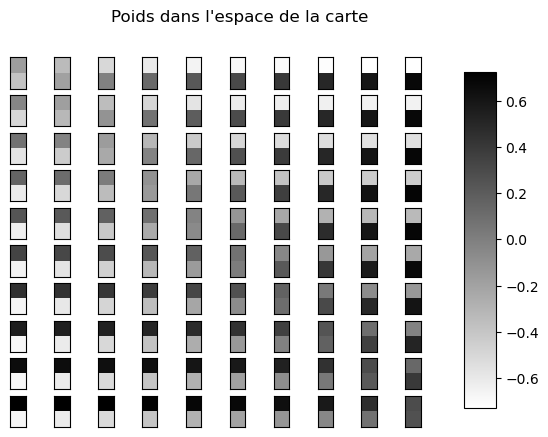

Sigma: 1.9000000000000001
Erreur de quantification vectorielle moyenne: 0.02275078144512158
Distorsion locale moyenne: 0.025026198080199017
Rugosité locale moyenne: 0.025026198080198993


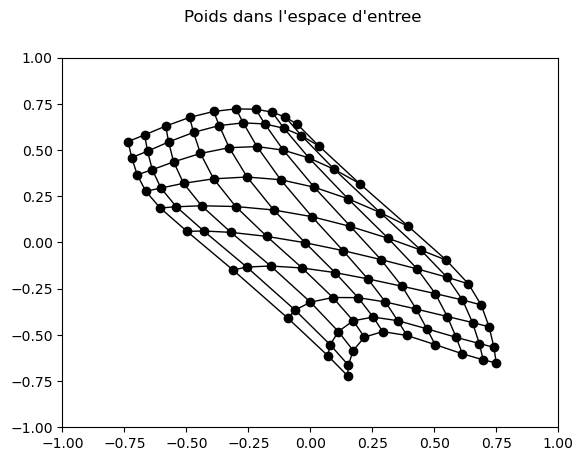

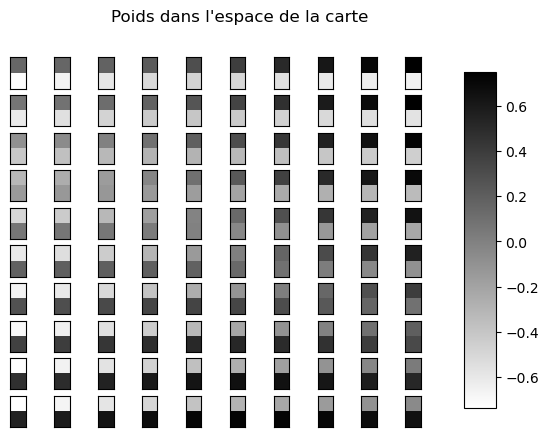

Sigma: 2.0
Erreur de quantification vectorielle moyenne: 0.024982537396988434
Distorsion locale moyenne: 0.021845644422136164
Rugosité locale moyenne: 0.02184564442213617


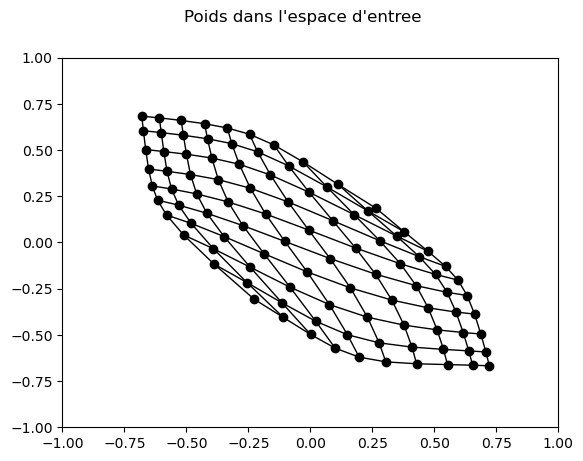

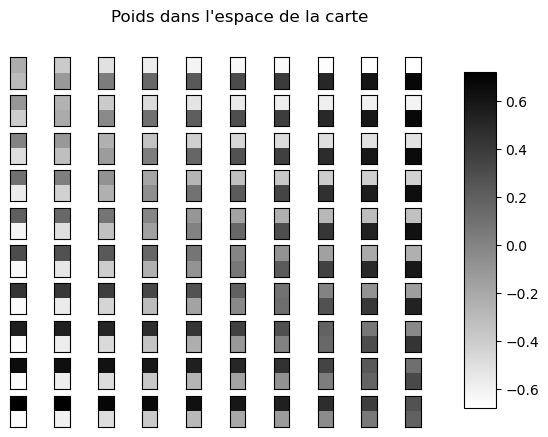

Sigma: 2.1
Erreur de quantification vectorielle moyenne: 0.029565662325066314
Distorsion locale moyenne: 0.021102297582423397
Rugosité locale moyenne: 0.021102297582423386


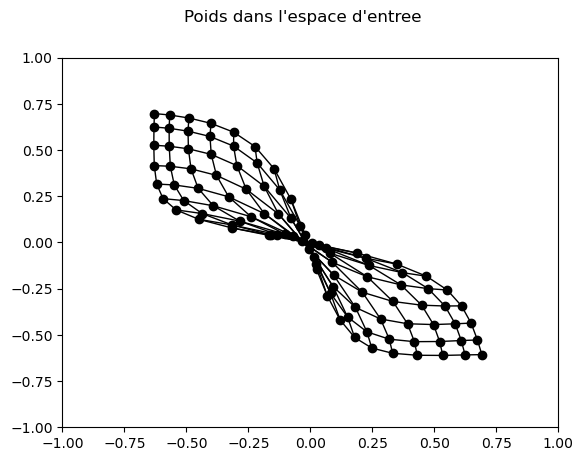

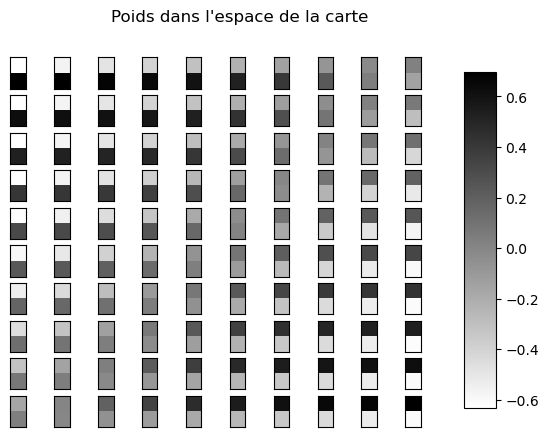

Sigma: 2.2
Erreur de quantification vectorielle moyenne: 0.03893703524934408
Distorsion locale moyenne: 0.019527831043906044
Rugosité locale moyenne: 0.019527831043906048


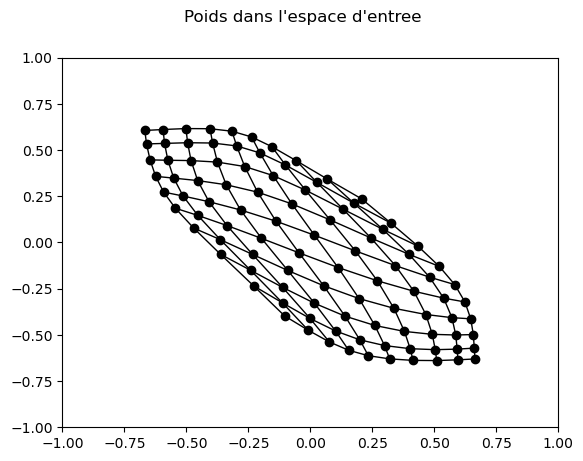

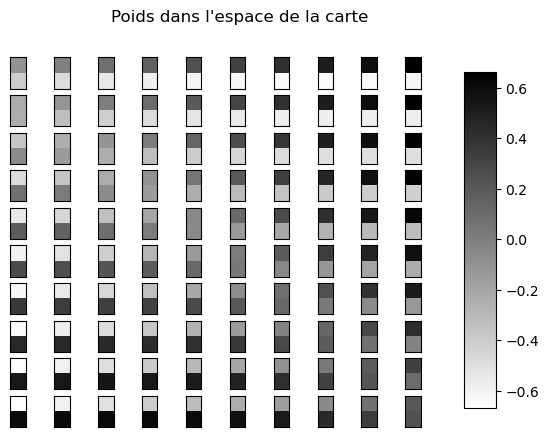

Sigma: 2.3000000000000003
Erreur de quantification vectorielle moyenne: 0.03733526303398888
Distorsion locale moyenne: 0.01912781167106351
Rugosité locale moyenne: 0.01912781167106352


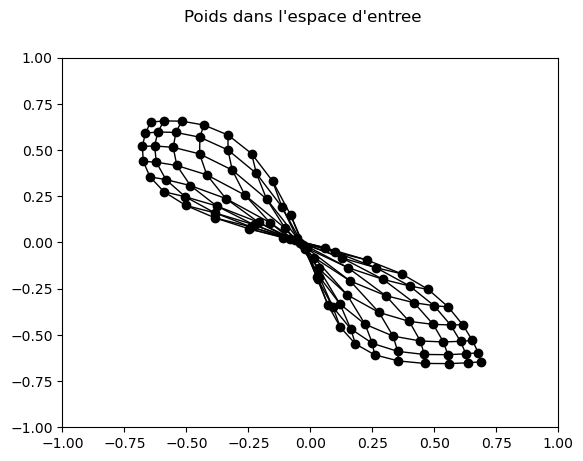

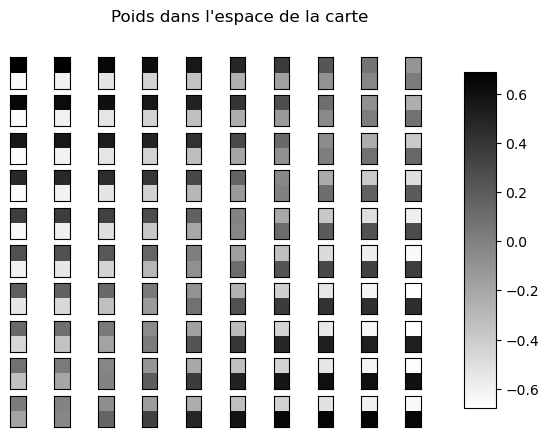

Sigma: 2.4000000000000004
Erreur de quantification vectorielle moyenne: 0.040578544454694
Distorsion locale moyenne: 0.02101258296144271
Rugosité locale moyenne: 0.021012582961442695


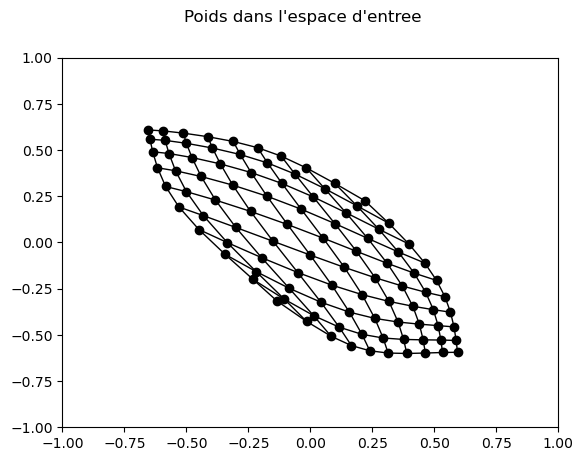

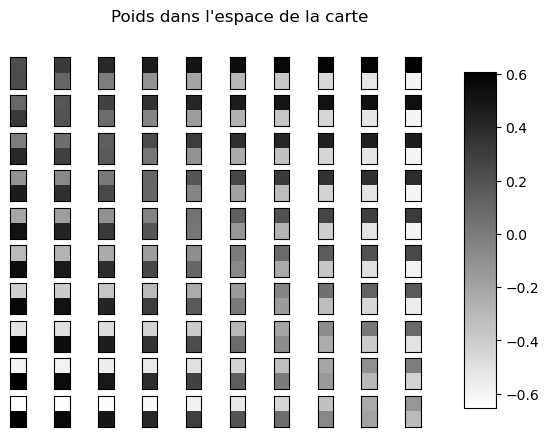

Sigma: 2.5000000000000004
Erreur de quantification vectorielle moyenne: 0.04872181832240206
Distorsion locale moyenne: 0.016655199343996906
Rugosité locale moyenne: 0.016655199343996913


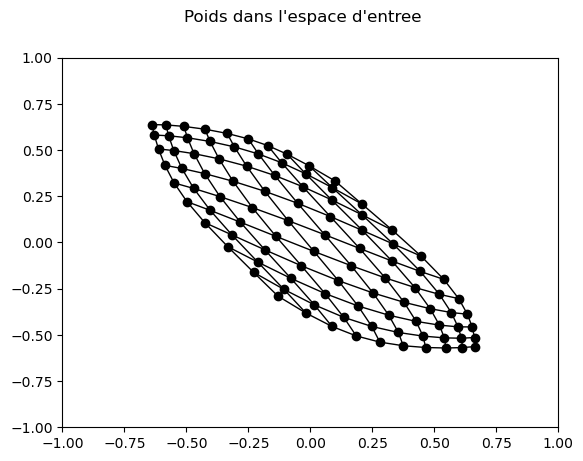

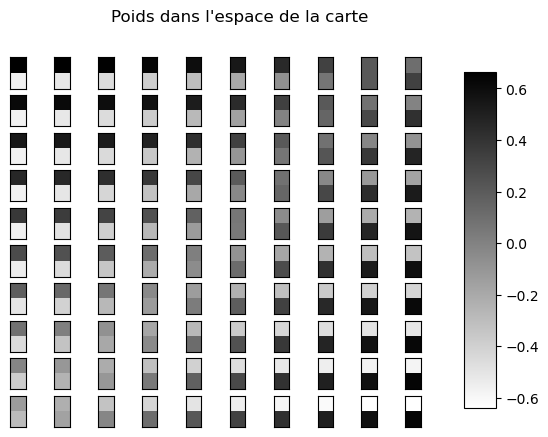

Sigma: 2.6
Erreur de quantification vectorielle moyenne: 0.046961655802667396
Distorsion locale moyenne: 0.017465615524991707
Rugosité locale moyenne: 0.017465615524991717


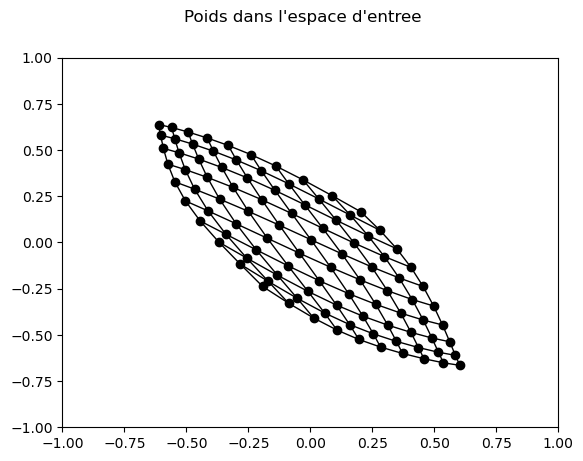

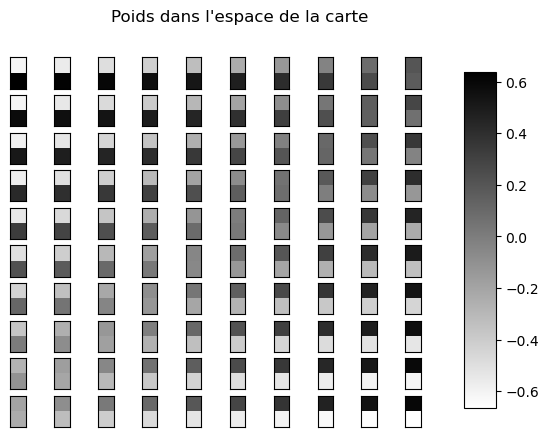

Sigma: 2.7
Erreur de quantification vectorielle moyenne: 0.054452429021762686
Distorsion locale moyenne: 0.01510053742259282
Rugosité locale moyenne: 0.015100537422592826


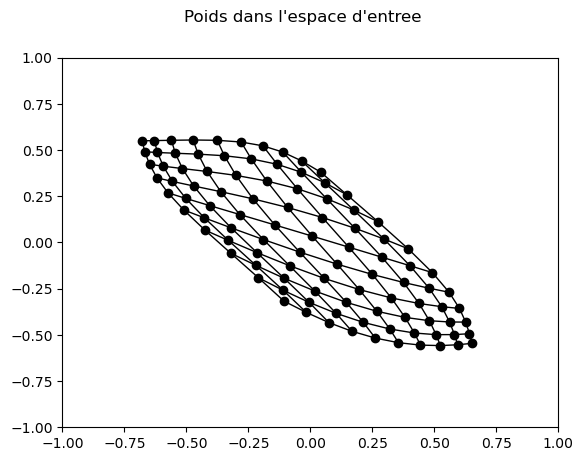

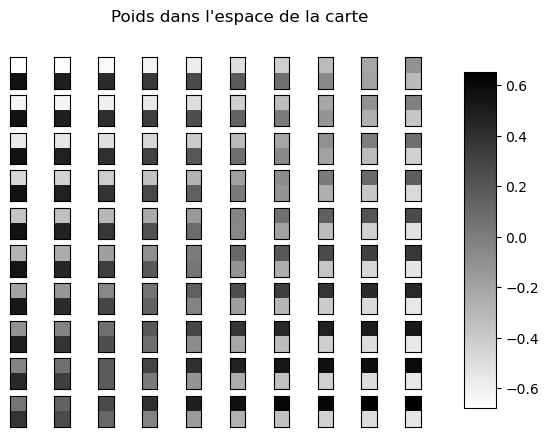

Sigma: 2.8000000000000003
Erreur de quantification vectorielle moyenne: 0.051014519867665524
Distorsion locale moyenne: 0.01603636560278481
Rugosité locale moyenne: 0.016036365602784805


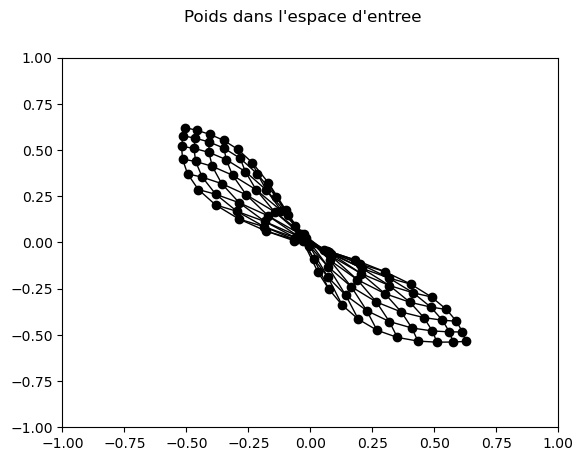

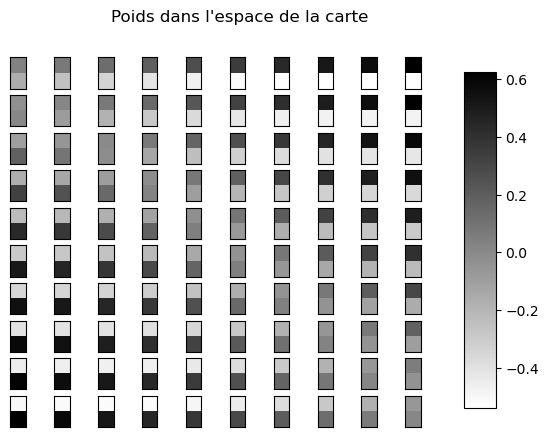

Sigma: 2.9000000000000004
Erreur de quantification vectorielle moyenne: 0.07014468078721536
Distorsion locale moyenne: 0.014205288759135268
Rugosité locale moyenne: 0.014205288759135275


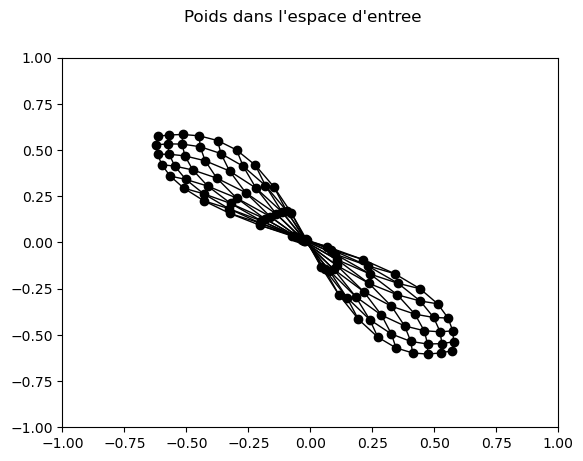

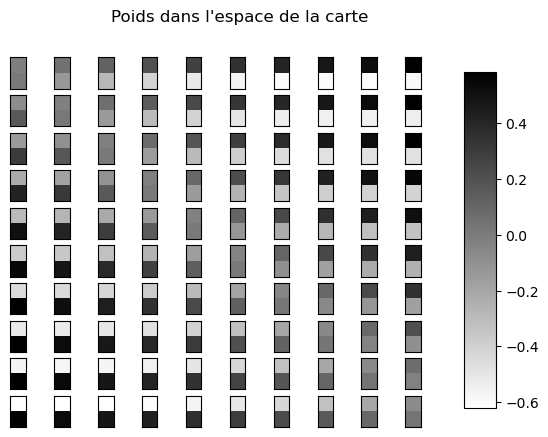

Sigma: 3.0000000000000004
Erreur de quantification vectorielle moyenne: 0.06204081712540233
Distorsion locale moyenne: 0.01680171274053863
Rugosité locale moyenne: 0.016801712740538606


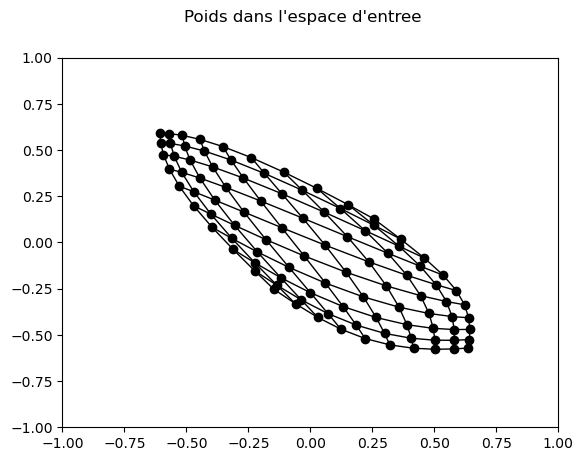

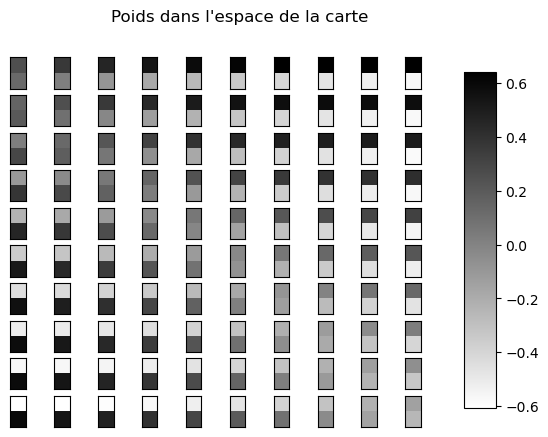

Sigma: 3.1
Erreur de quantification vectorielle moyenne: 0.05411555167300967
Distorsion locale moyenne: 0.01614128385077385
Rugosité locale moyenne: 0.01614128385077385


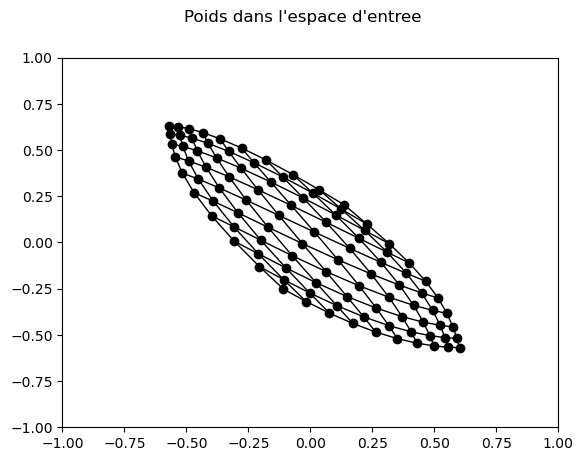

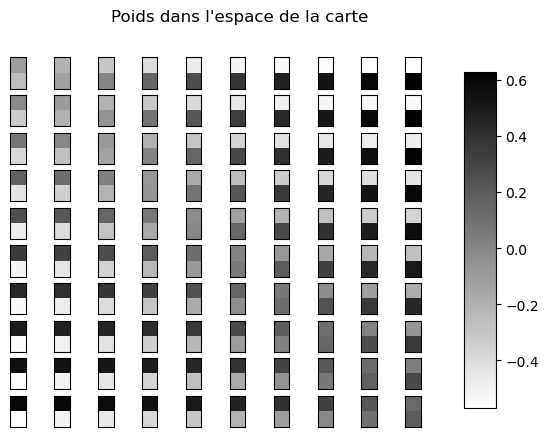

Sigma: 3.2
Erreur de quantification vectorielle moyenne: 0.06298652303562804
Distorsion locale moyenne: 0.015147149317362146
Rugosité locale moyenne: 0.015147149317362135


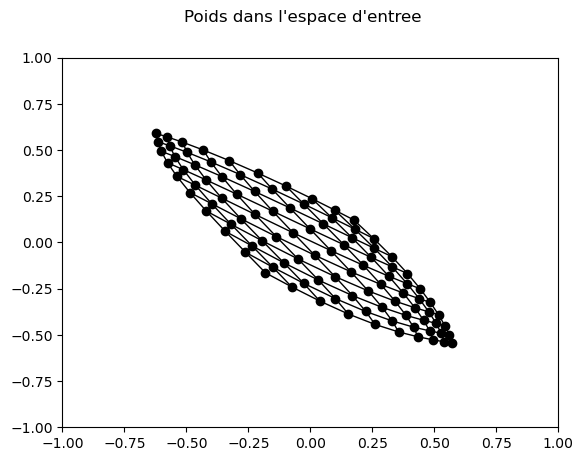

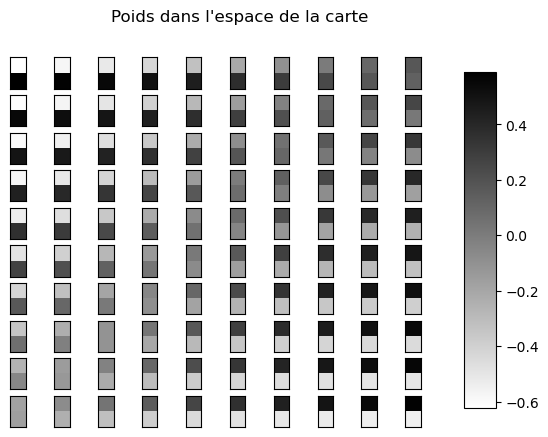

Sigma: 3.3000000000000003
Erreur de quantification vectorielle moyenne: 0.07298259377588982
Distorsion locale moyenne: 0.013614448922576735
Rugosité locale moyenne: 0.013614448922576737


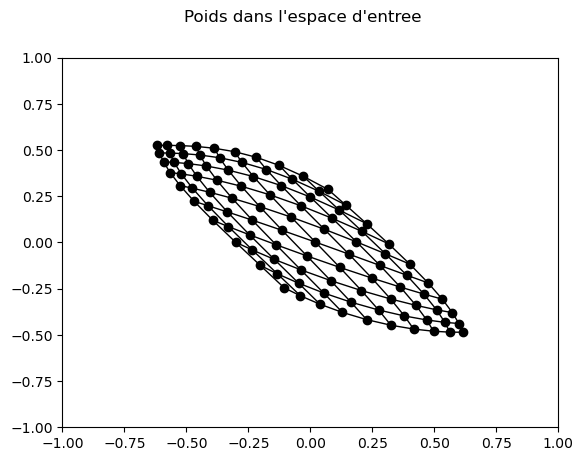

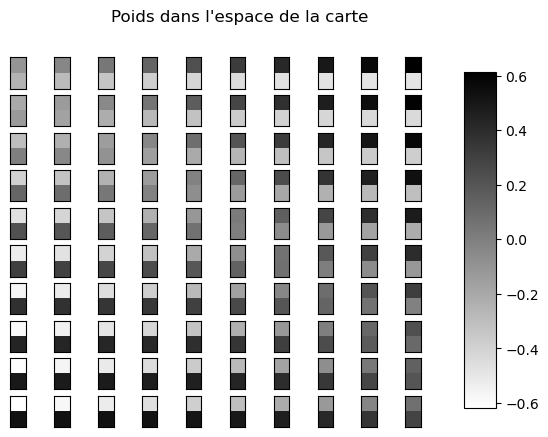

Sigma: 3.4000000000000004
Erreur de quantification vectorielle moyenne: 0.07232579323663747
Distorsion locale moyenne: 0.013077083787520606
Rugosité locale moyenne: 0.013077083787520621


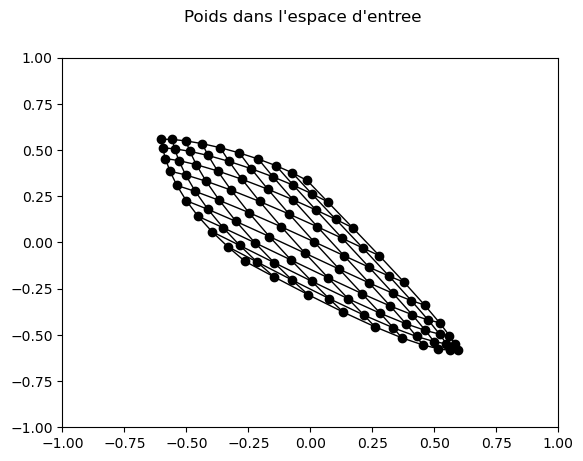

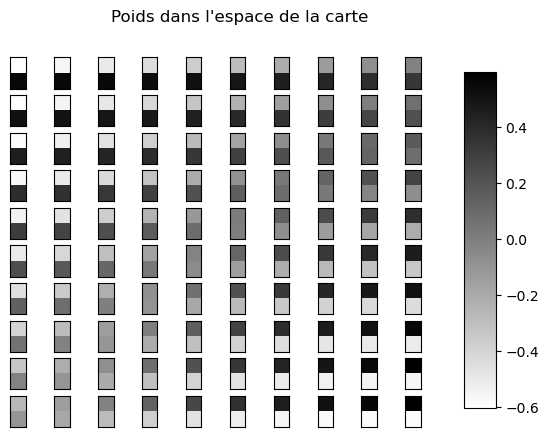

Sigma: 3.5000000000000004
Erreur de quantification vectorielle moyenne: 0.06806721605616443
Distorsion locale moyenne: 0.014470905927451908
Rugosité locale moyenne: 0.014470905927451903


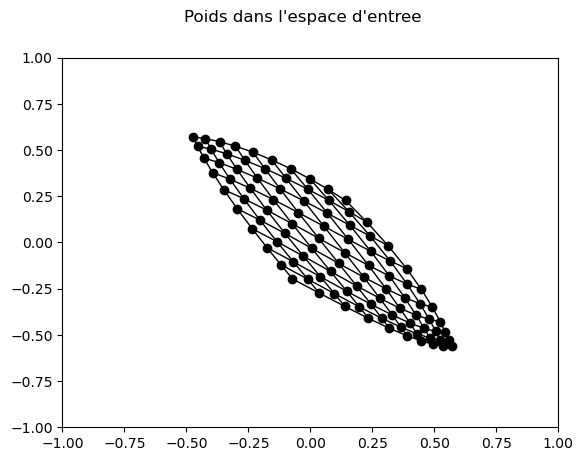

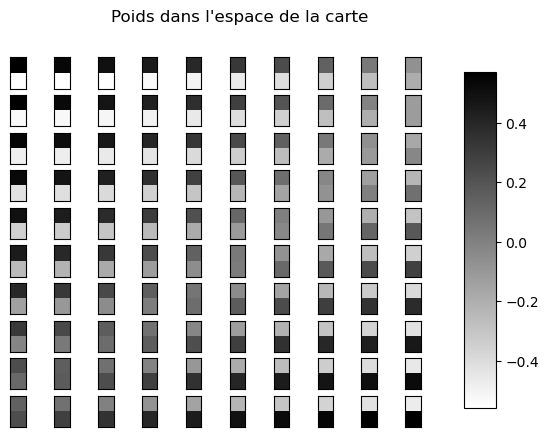

Sigma: 3.6
Erreur de quantification vectorielle moyenne: 0.08661103410190608
Distorsion locale moyenne: 0.011885419221155378
Rugosité locale moyenne: 0.011885419221155385


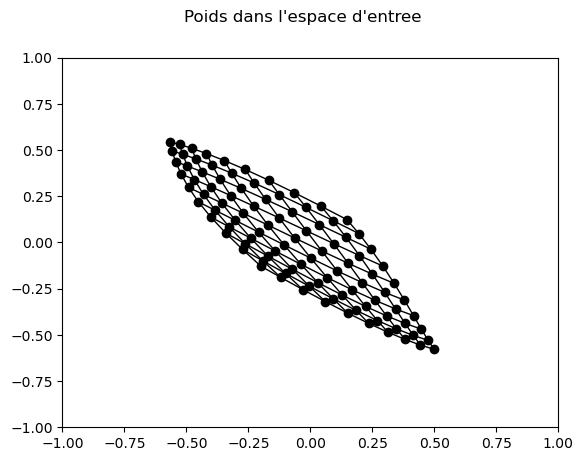

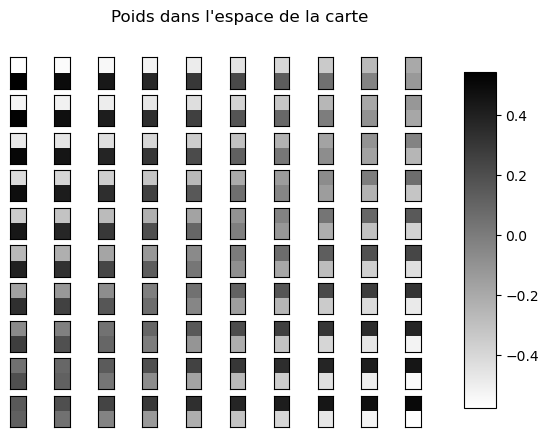

Sigma: 3.7
Erreur de quantification vectorielle moyenne: 0.087356407307996
Distorsion locale moyenne: 0.010556004553006744
Rugosité locale moyenne: 0.010556004553006738


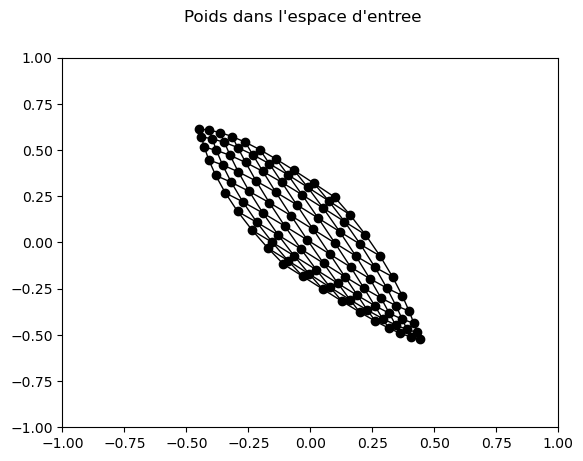

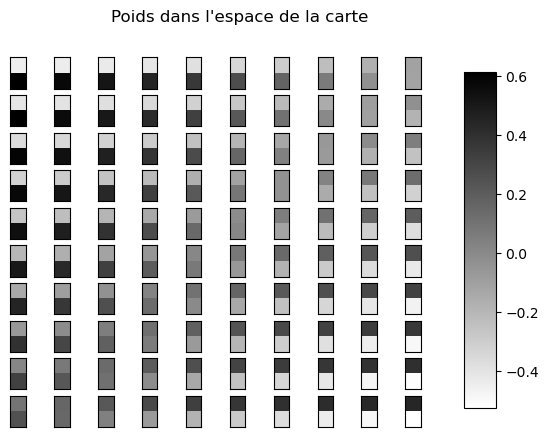

Sigma: 3.8000000000000003
Erreur de quantification vectorielle moyenne: 0.10360314267208966
Distorsion locale moyenne: 0.010245256675259011
Rugosité locale moyenne: 0.010245256675259015


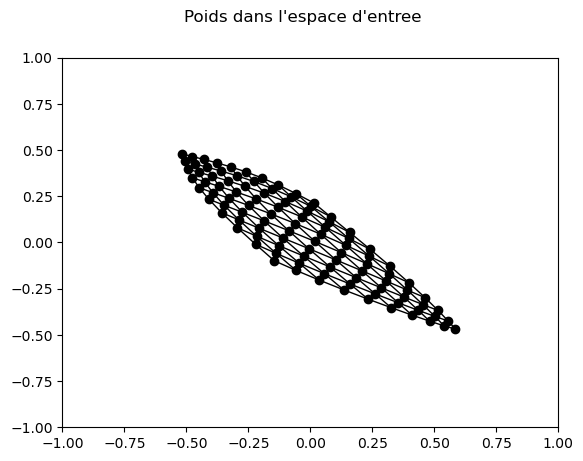

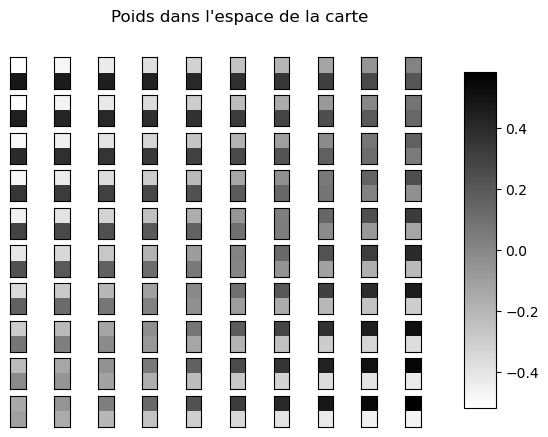

Sigma: 3.9000000000000004
Erreur de quantification vectorielle moyenne: 0.10191702142103297
Distorsion locale moyenne: 0.00942397433224664
Rugosité locale moyenne: 0.009423974332246645


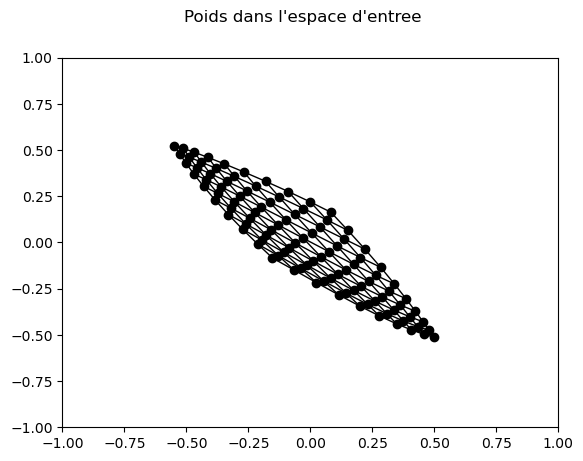

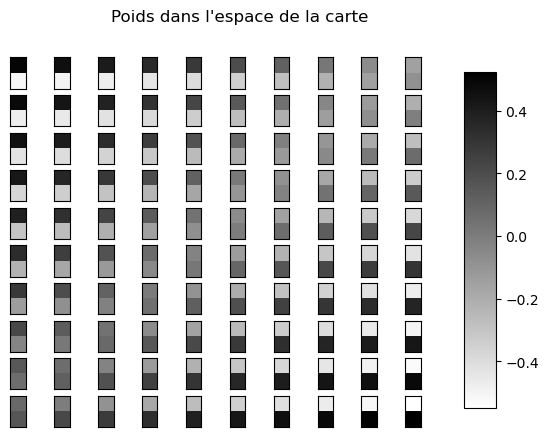

Sigma: 4.0
Erreur de quantification vectorielle moyenne: 0.09950809242777167
Distorsion locale moyenne: 0.00968593461143946
Rugosité locale moyenne: 0.009685934611439462


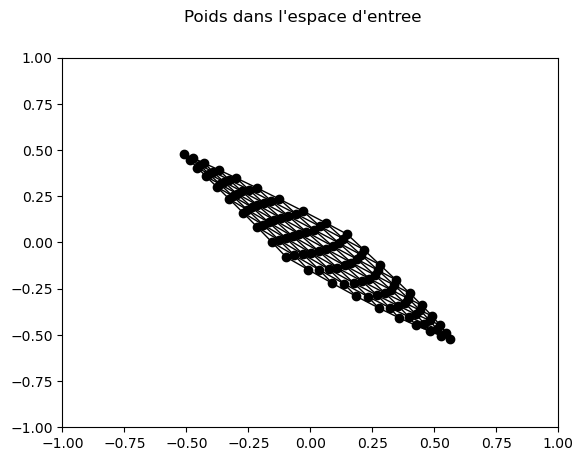

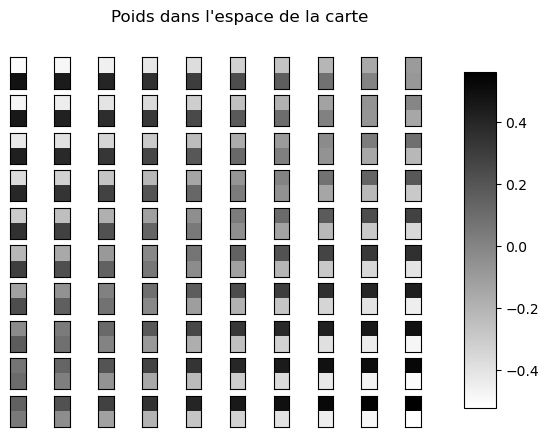

Sigma: 4.1
Erreur de quantification vectorielle moyenne: 0.10482950655515033
Distorsion locale moyenne: 0.009608159429705004
Rugosité locale moyenne: 0.009608159429705002


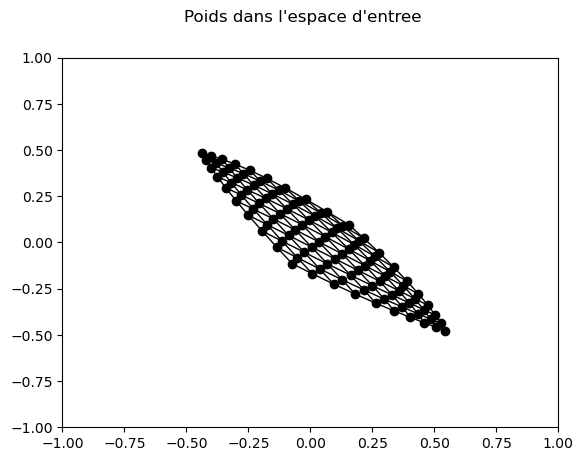

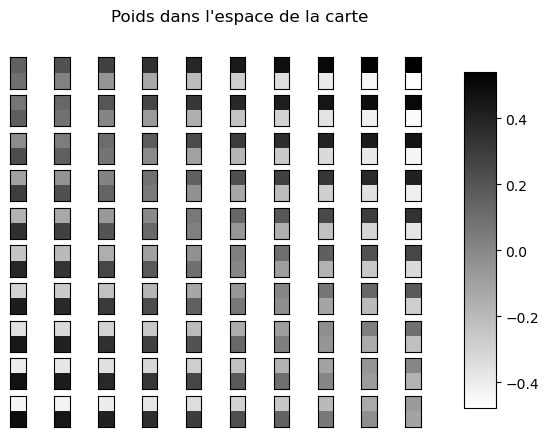

Sigma: 4.2
Erreur de quantification vectorielle moyenne: 0.1149138500212436
Distorsion locale moyenne: 0.008487193157718216
Rugosité locale moyenne: 0.008487193157718223


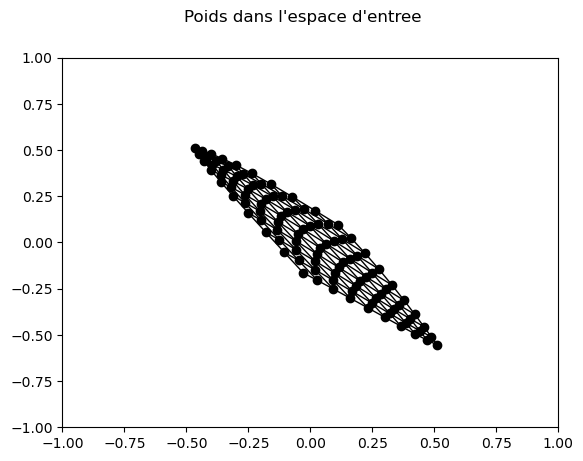

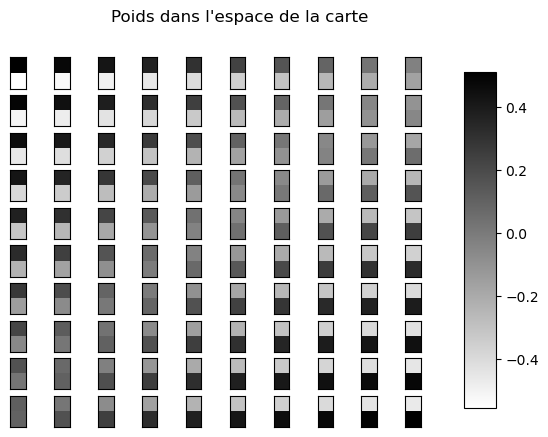

Sigma: 4.3
Erreur de quantification vectorielle moyenne: 0.10740264169303072
Distorsion locale moyenne: 0.009378943996404156
Rugosité locale moyenne: 0.009378943996404163


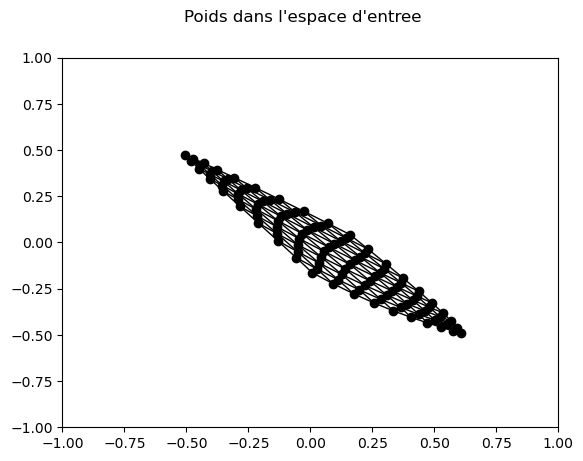

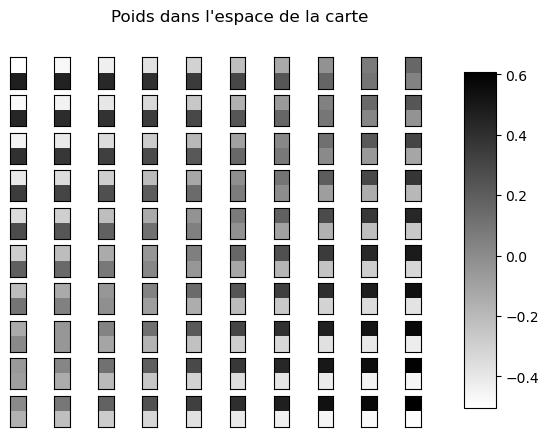

Sigma: 4.3999999999999995
Erreur de quantification vectorielle moyenne: 0.105172521684432
Distorsion locale moyenne: 0.009823014555729545
Rugosité locale moyenne: 0.009823014555729545


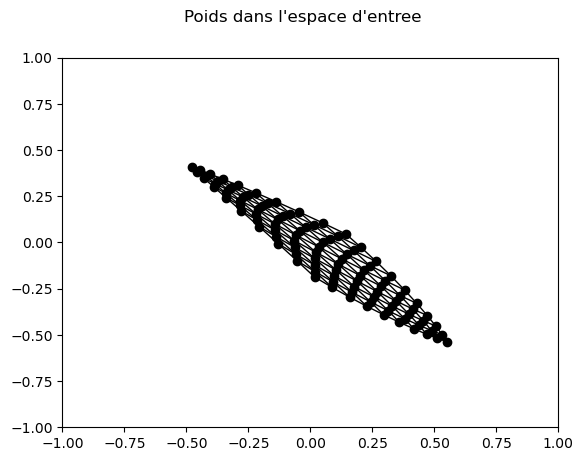

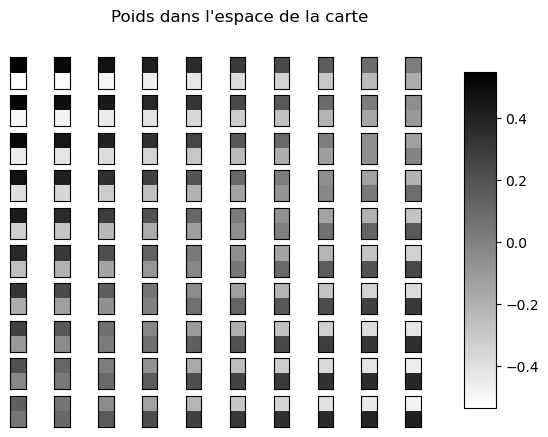

Sigma: 4.5
Erreur de quantification vectorielle moyenne: 0.11498025740548146
Distorsion locale moyenne: 0.008686225618612804
Rugosité locale moyenne: 0.008686225618612809


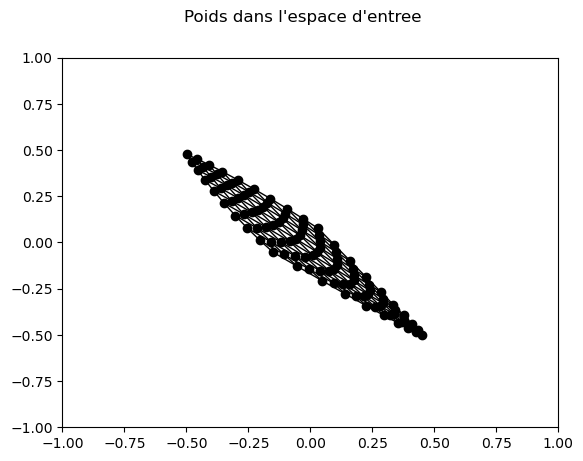

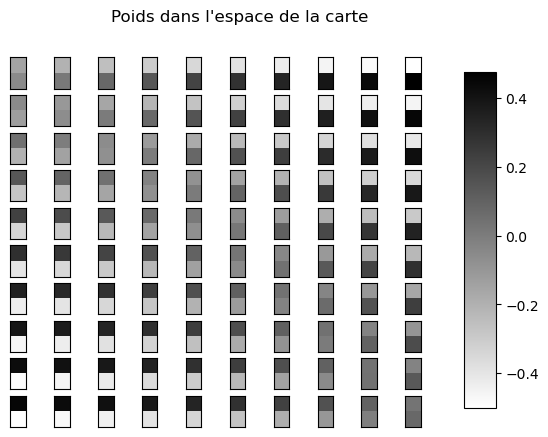

Sigma: 4.6
Erreur de quantification vectorielle moyenne: 0.1200500036459457
Distorsion locale moyenne: 0.008286104588147065
Rugosité locale moyenne: 0.008286104588147067


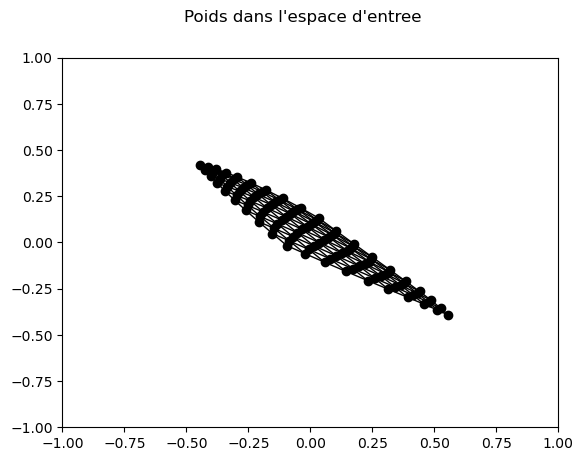

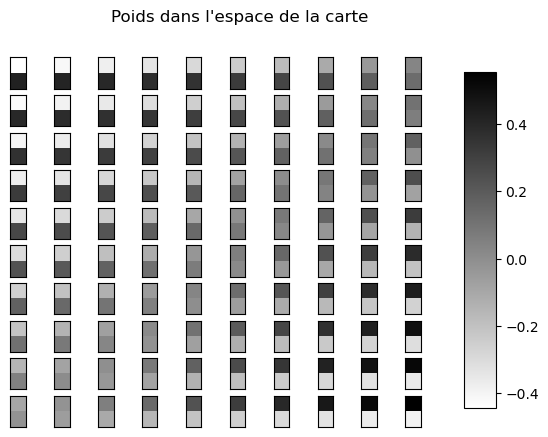

Sigma: 4.7
Erreur de quantification vectorielle moyenne: 0.13620998555483632
Distorsion locale moyenne: 0.007029954432081495
Rugosité locale moyenne: 0.007029954432081498


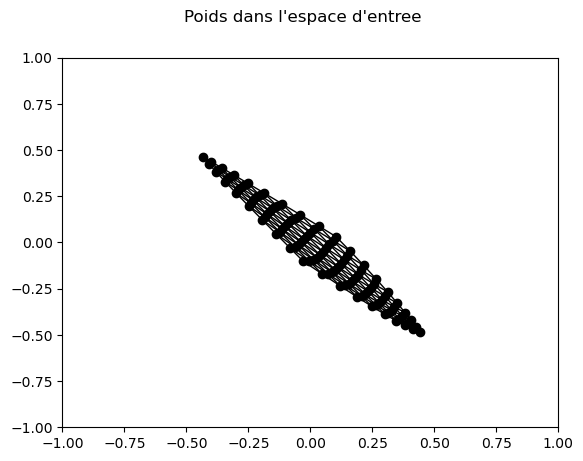

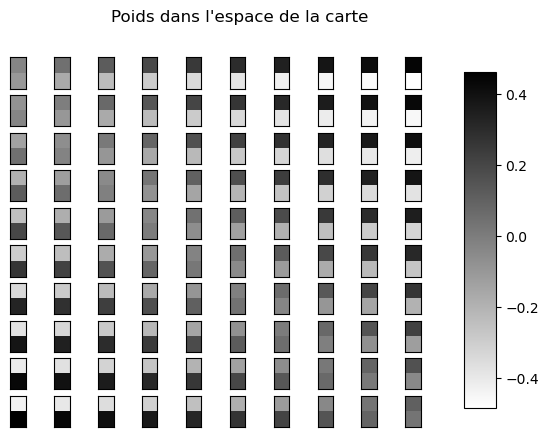

Sigma: 4.8
Erreur de quantification vectorielle moyenne: 0.131438381088648
Distorsion locale moyenne: 0.007225305051454467
Rugosité locale moyenne: 0.007225305051454473


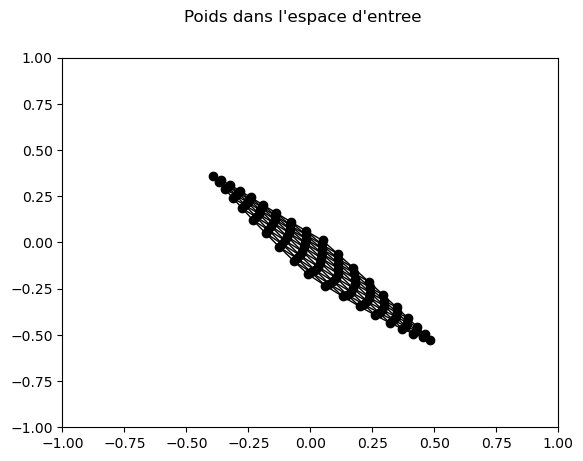

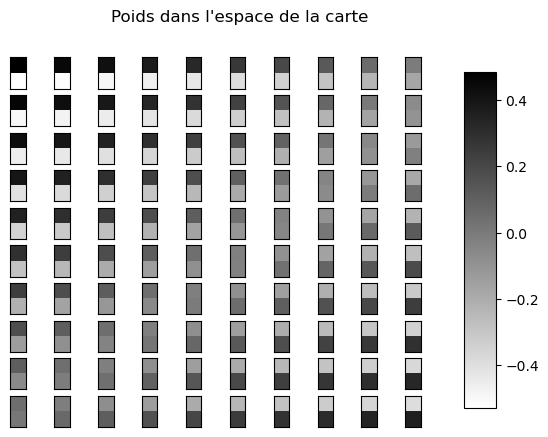

Sigma: 4.9
Erreur de quantification vectorielle moyenne: 0.14263507471371312
Distorsion locale moyenne: 0.006639599099510557
Rugosité locale moyenne: 0.006639599099510557


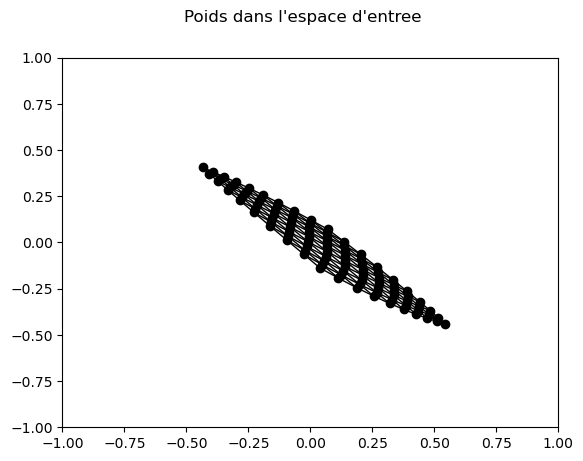

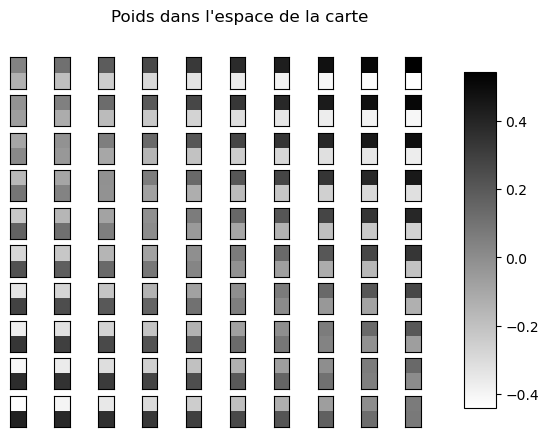

Sigma: 5.0
Erreur de quantification vectorielle moyenne: 0.13236520864033974
Distorsion locale moyenne: 0.006992111080279431
Rugosité locale moyenne: 0.006992111080279421


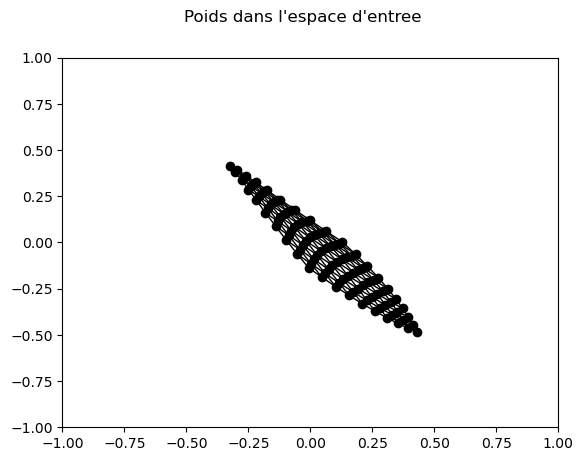

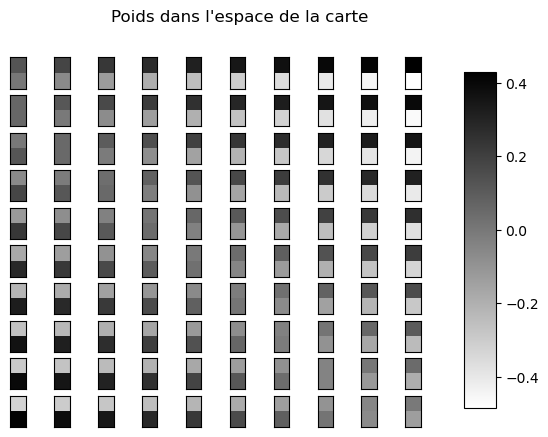

Sigma: 5.1
Erreur de quantification vectorielle moyenne: 0.15514870196837685
Distorsion locale moyenne: 0.00561848315896558
Rugosité locale moyenne: 0.005618483158965596


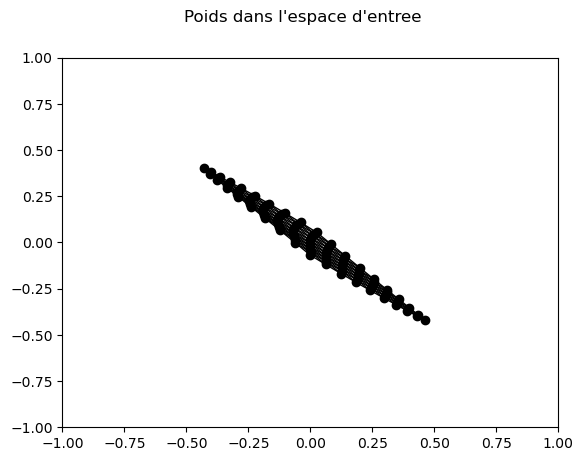

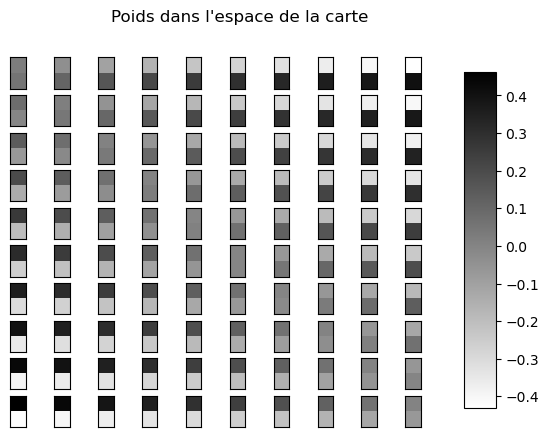

Sigma: 5.2
Erreur de quantification vectorielle moyenne: 0.14623978153256473
Distorsion locale moyenne: 0.005939680155092528
Rugosité locale moyenne: 0.005939680155092535


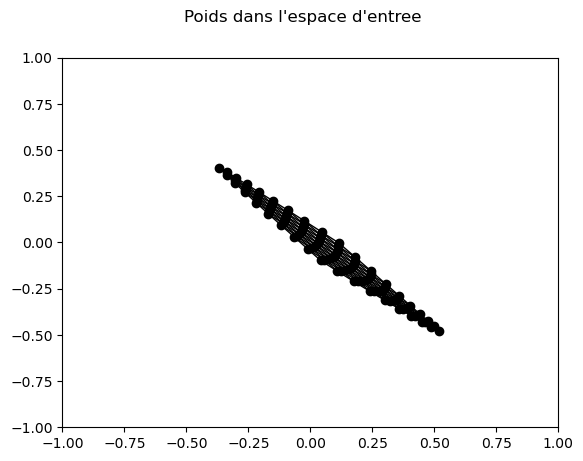

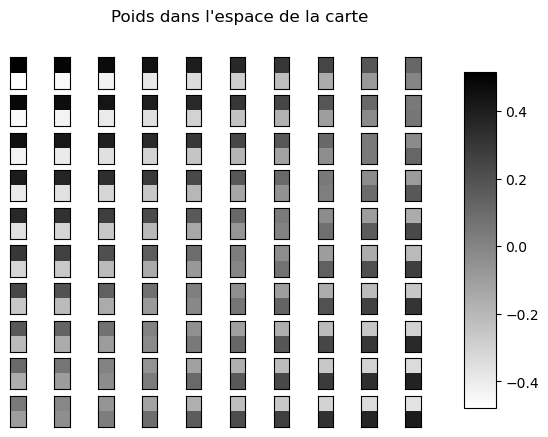

Sigma: 5.3
Erreur de quantification vectorielle moyenne: 0.1432047414639273
Distorsion locale moyenne: 0.006492304273171624
Rugosité locale moyenne: 0.006492304273171618


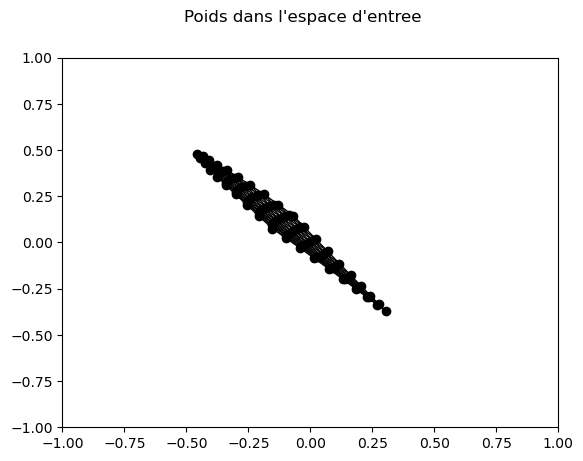

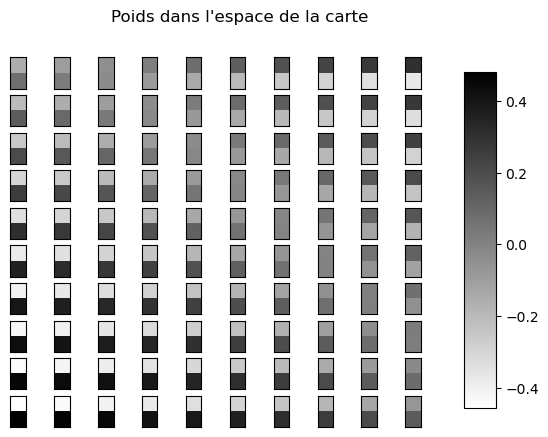

Sigma: 5.4
Erreur de quantification vectorielle moyenne: 0.16602084440321516
Distorsion locale moyenne: 0.005307467451667221
Rugosité locale moyenne: 0.005307467451667232


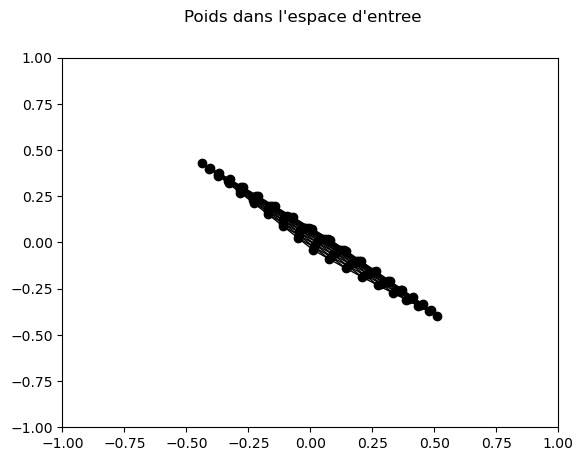

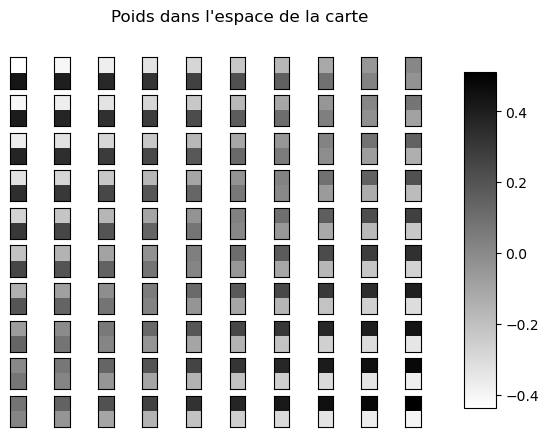

Sigma: 5.5
Erreur de quantification vectorielle moyenne: 0.1415842490112797
Distorsion locale moyenne: 0.006366601430387533
Rugosité locale moyenne: 0.0063666014303875315


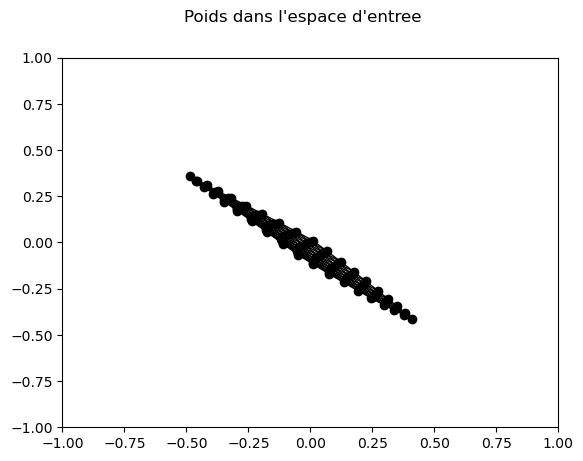

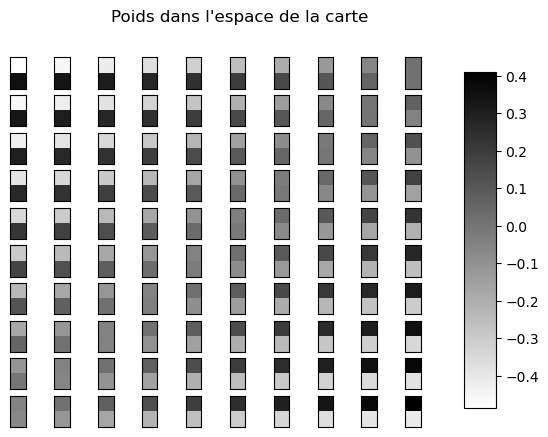

Sigma: 5.6
Erreur de quantification vectorielle moyenne: 0.15558154165197025
Distorsion locale moyenne: 0.005606074196328566
Rugosité locale moyenne: 0.005606074196328571


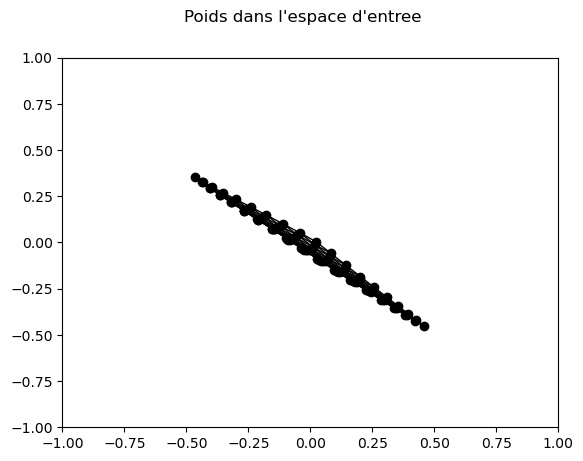

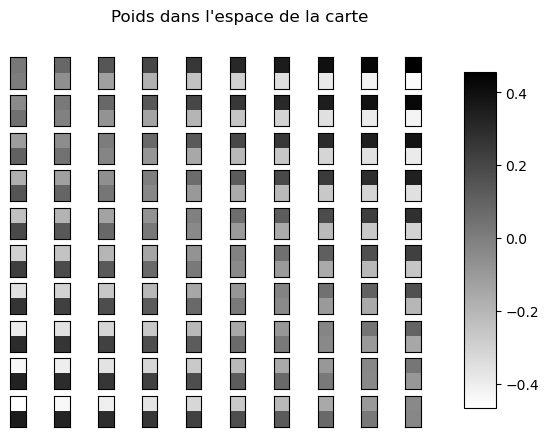

Sigma: 5.7
Erreur de quantification vectorielle moyenne: 0.14831690690934457
Distorsion locale moyenne: 0.005915541960213807
Rugosité locale moyenne: 0.005915541960213806


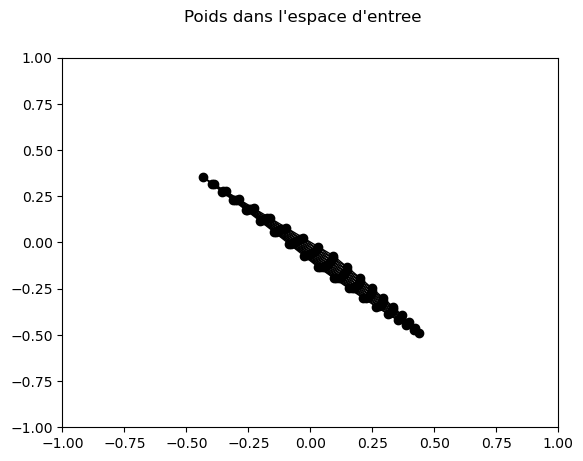

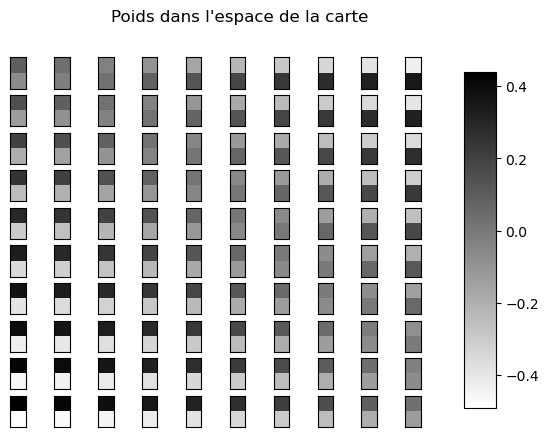

Sigma: 5.8
Erreur de quantification vectorielle moyenne: 0.14982158440877255
Distorsion locale moyenne: 0.005793236485376788
Rugosité locale moyenne: 0.005793236485376789


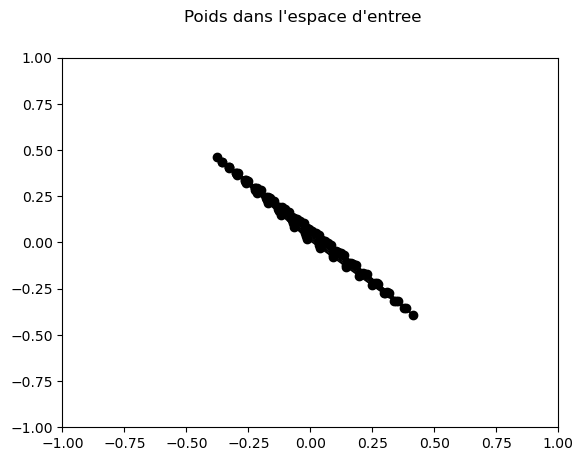

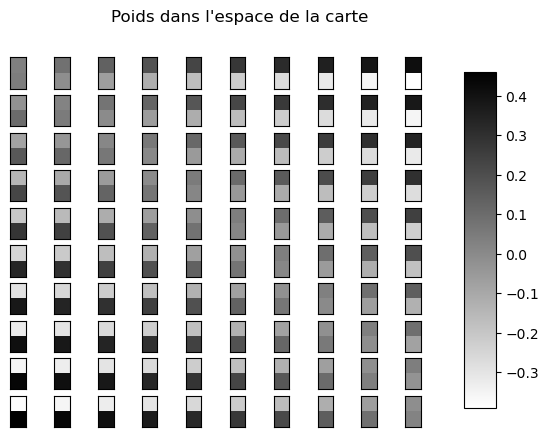

Sigma: 5.9
Erreur de quantification vectorielle moyenne: 0.15882287201097323
Distorsion locale moyenne: 0.005294440364731755
Rugosité locale moyenne: 0.005294440364731761


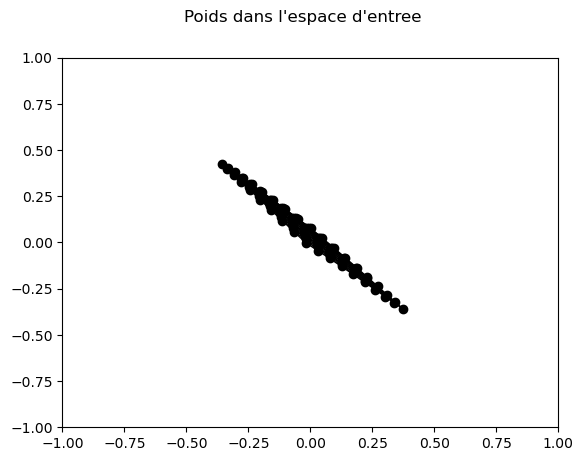

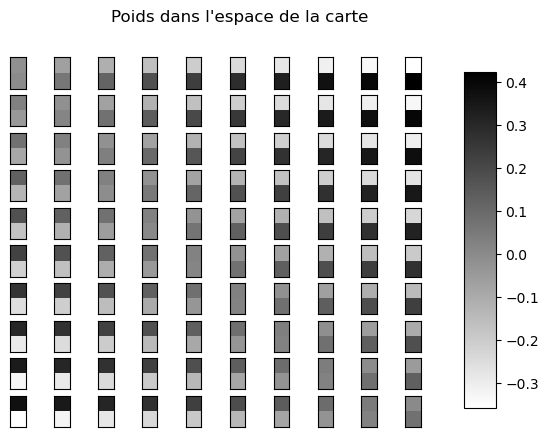

Sigma: 6.0
Erreur de quantification vectorielle moyenne: 0.1767785490788368
Distorsion locale moyenne: 0.004346957155685615
Rugosité locale moyenne: 0.004346957155685611


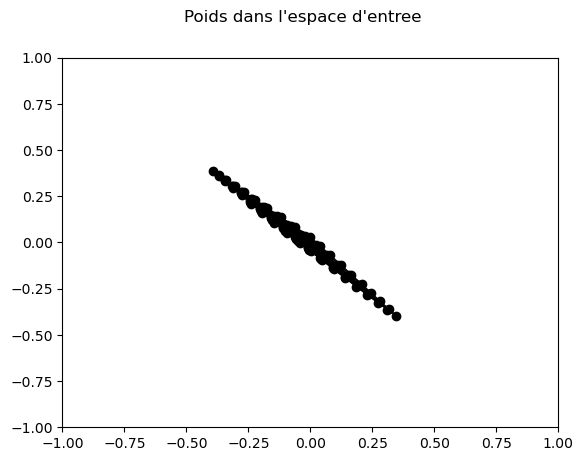

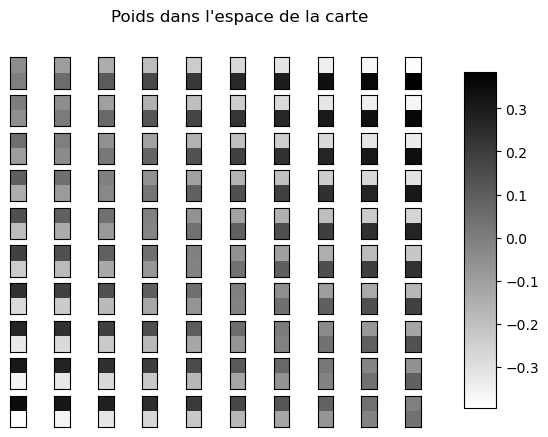

Sigma: 6.1
Erreur de quantification vectorielle moyenne: 0.17521125512586033
Distorsion locale moyenne: 0.00436116304910019
Rugosité locale moyenne: 0.004361163049100195


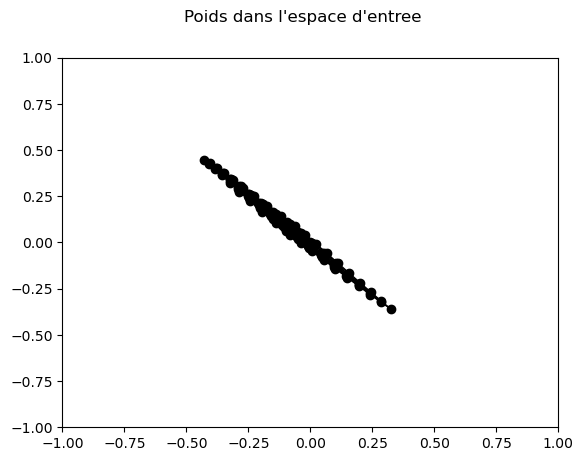

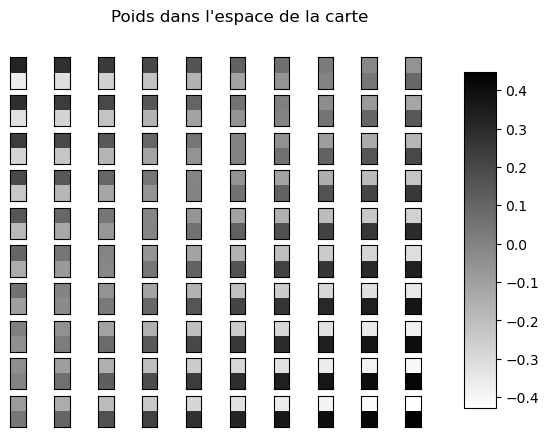

Sigma: 6.2
Erreur de quantification vectorielle moyenne: 0.17170386334853216
Distorsion locale moyenne: 0.004589704975139867
Rugosité locale moyenne: 0.0045897049751398656


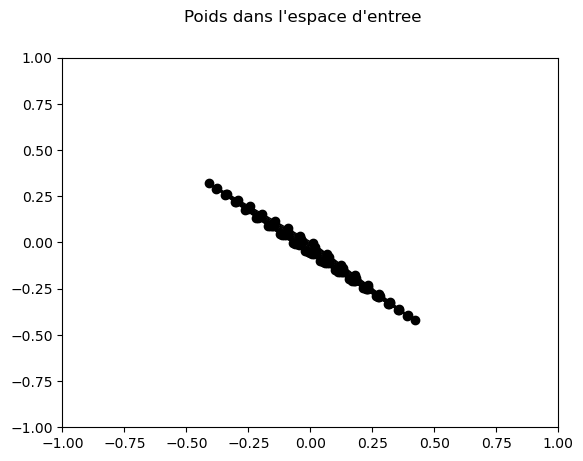

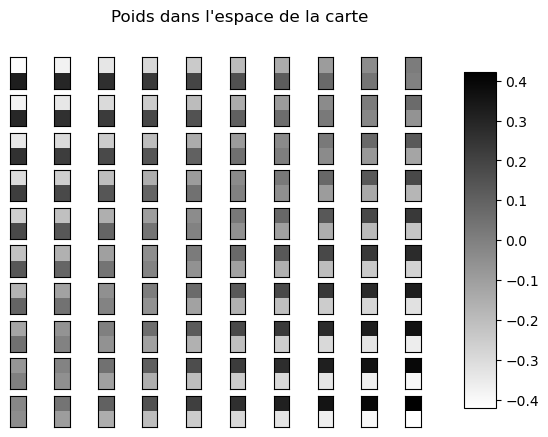

Sigma: 6.3
Erreur de quantification vectorielle moyenne: 0.167879352138794
Distorsion locale moyenne: 0.004641830277038768
Rugosité locale moyenne: 0.0046418302770387665


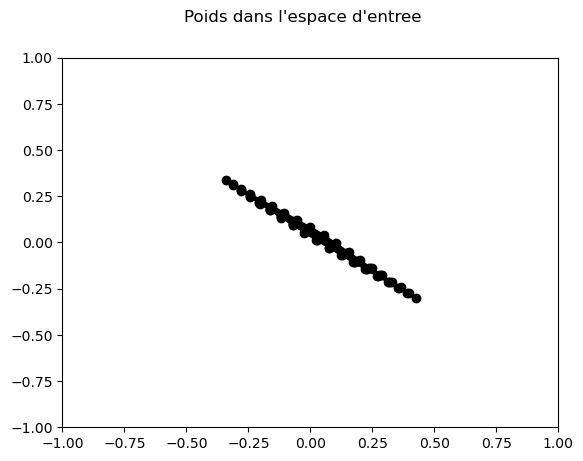

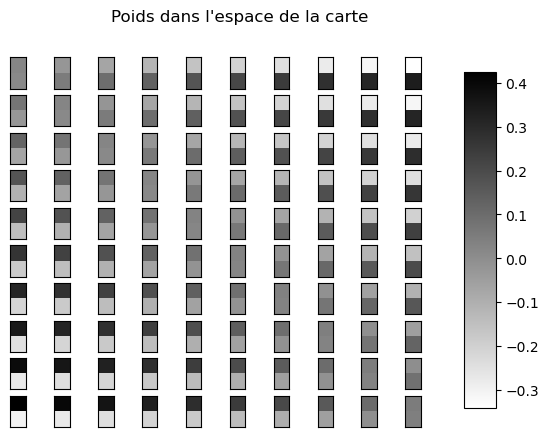

Sigma: 6.4
Erreur de quantification vectorielle moyenne: 0.196897476910526
Distorsion locale moyenne: 0.0036424124197876433
Rugosité locale moyenne: 0.003642412419787649


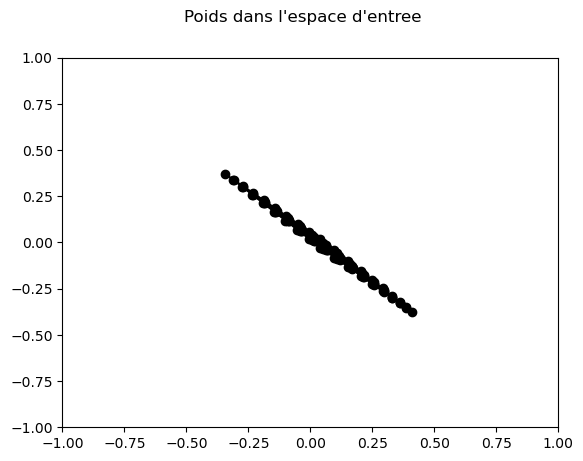

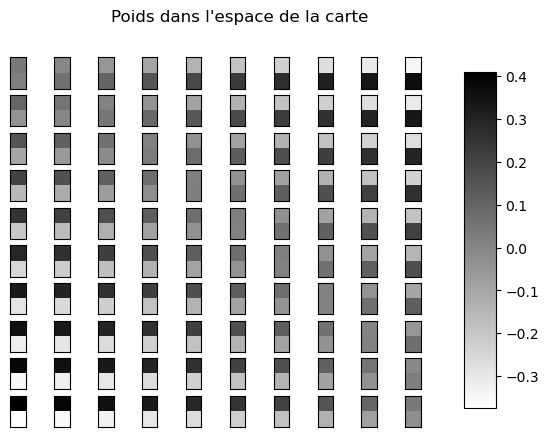

Sigma: 6.5
Erreur de quantification vectorielle moyenne: 0.1777344356754331
Distorsion locale moyenne: 0.004297312383109713
Rugosité locale moyenne: 0.0042973123831097195


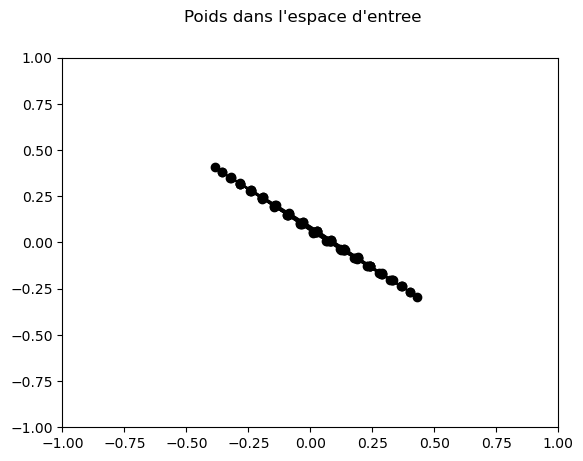

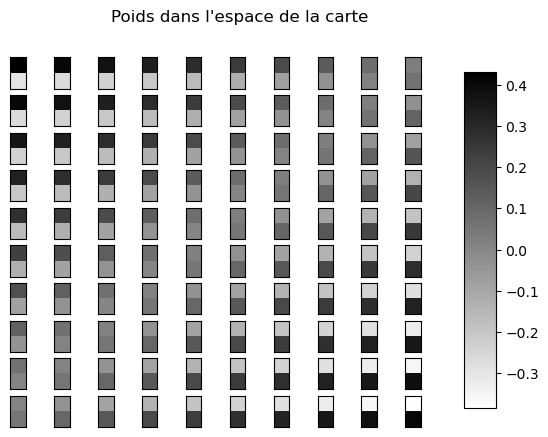

Sigma: 6.6
Erreur de quantification vectorielle moyenne: 0.1798995589869431
Distorsion locale moyenne: 0.004367759706922551
Rugosité locale moyenne: 0.004367759706922548


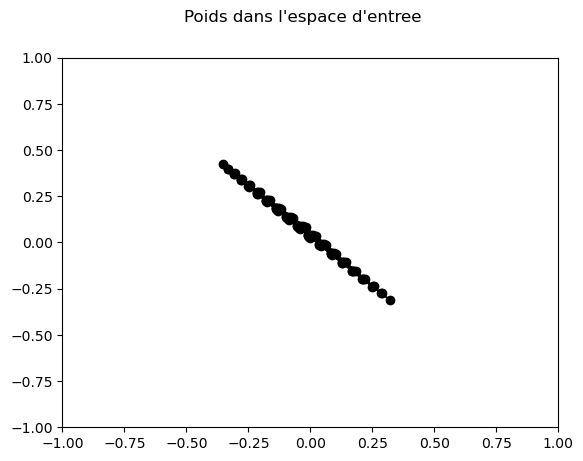

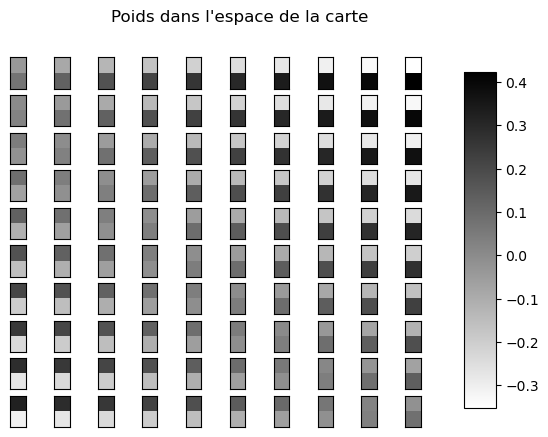

Sigma: 6.7
Erreur de quantification vectorielle moyenne: 0.19643938680648576
Distorsion locale moyenne: 0.003650716613184452
Rugosité locale moyenne: 0.0036507166131844538


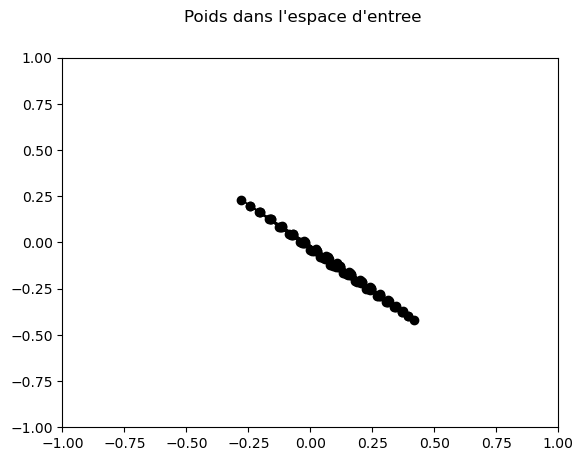

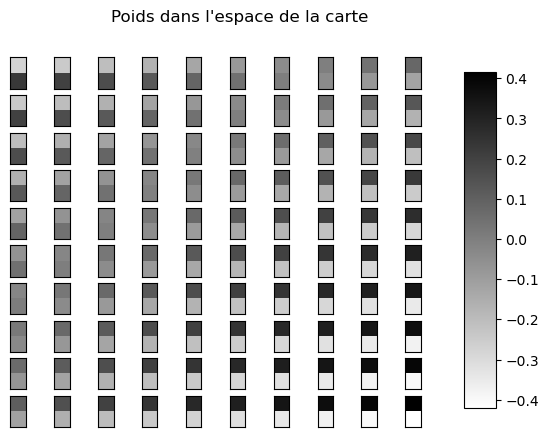

Sigma: 6.8
Erreur de quantification vectorielle moyenne: 0.21302643088605275
Distorsion locale moyenne: 0.0033128993330484888
Rugosité locale moyenne: 0.00331289933304849


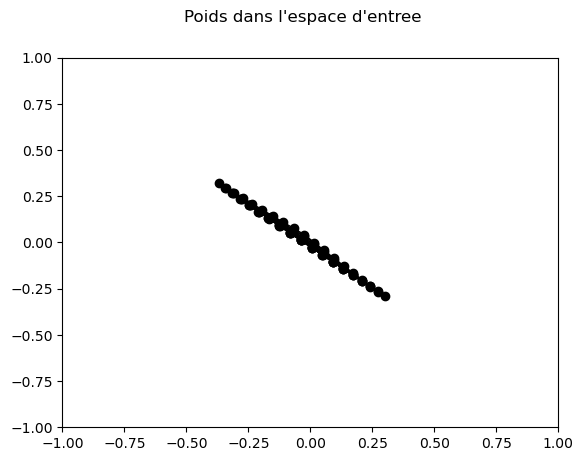

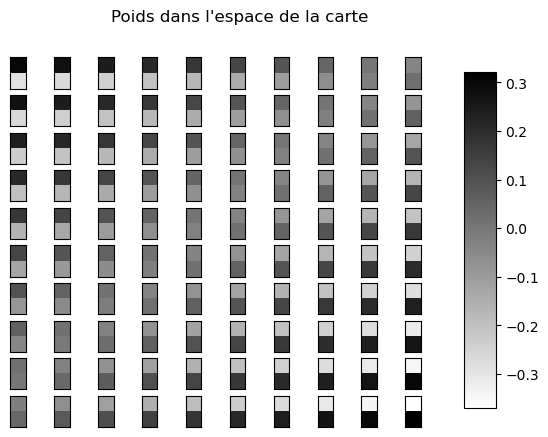

Sigma: 6.9
Erreur de quantification vectorielle moyenne: 0.21685078764049365
Distorsion locale moyenne: 0.0029346804387187907
Rugosité locale moyenne: 0.0029346804387187855


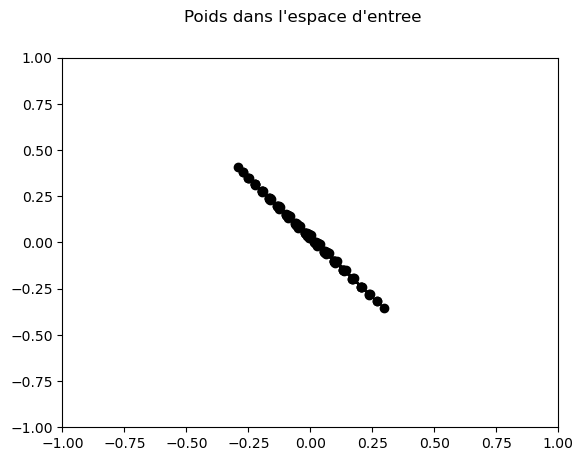

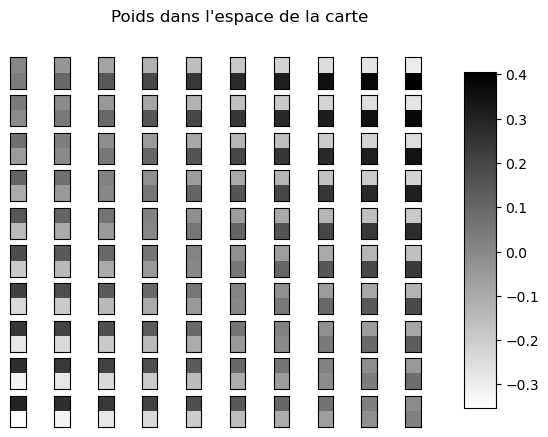

Sigma: 7.0
Erreur de quantification vectorielle moyenne: 0.20680906008423125
Distorsion locale moyenne: 0.0033695489448739616
Rugosité locale moyenne: 0.0033695489448739625


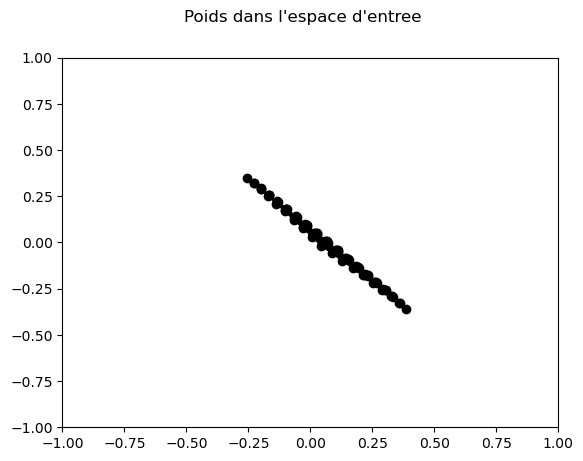

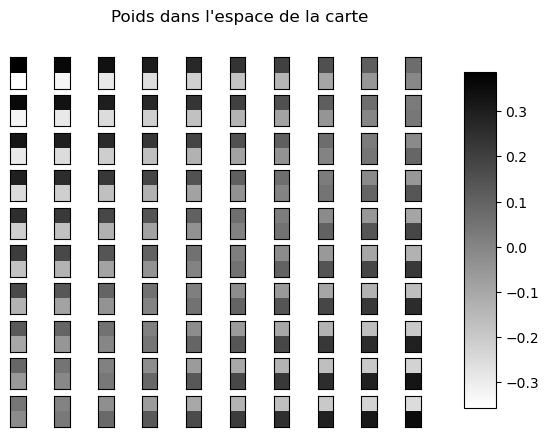

Sigma: 7.1
Erreur de quantification vectorielle moyenne: 0.2064239604556906
Distorsion locale moyenne: 0.0032572090826629542
Rugosité locale moyenne: 0.003257209082662952


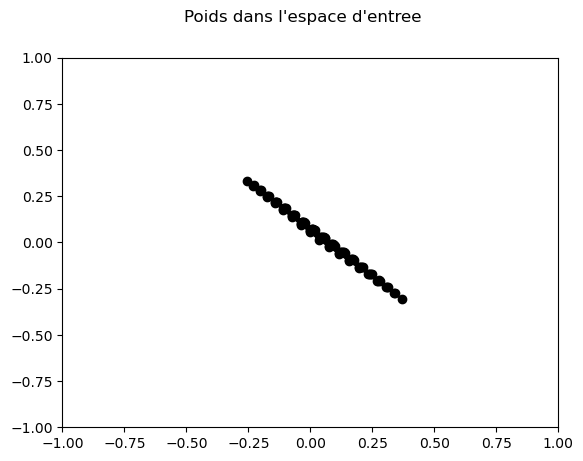

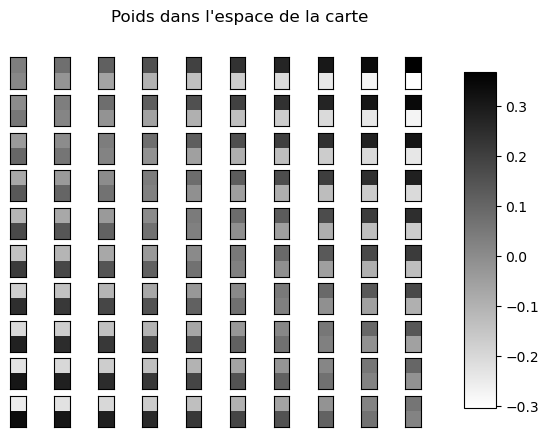

Sigma: 7.2
Erreur de quantification vectorielle moyenne: 0.2225149108048392
Distorsion locale moyenne: 0.002794644553331332
Rugosité locale moyenne: 0.002794644553331335


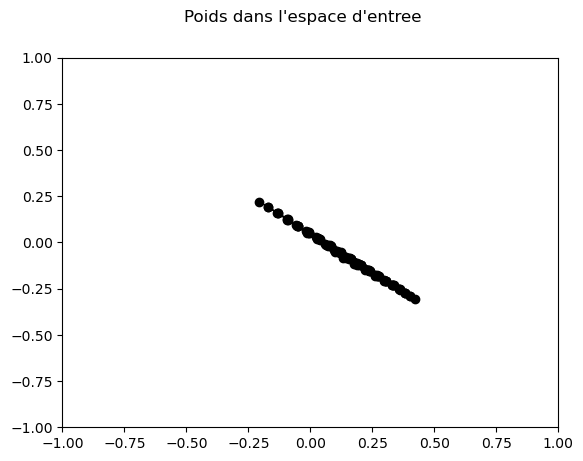

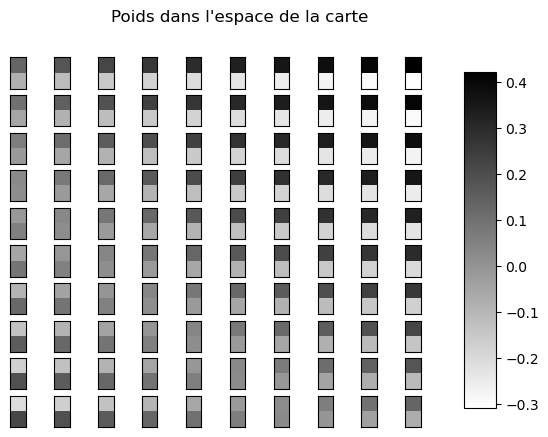

Sigma: 7.3
Erreur de quantification vectorielle moyenne: 0.25259971254965424
Distorsion locale moyenne: 0.002433338355096721
Rugosité locale moyenne: 0.0024333383550967204


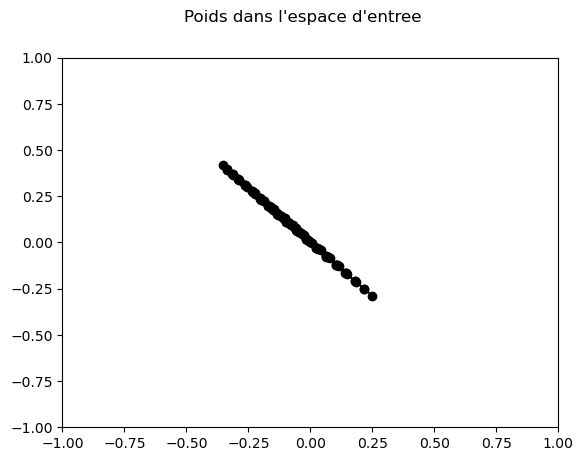

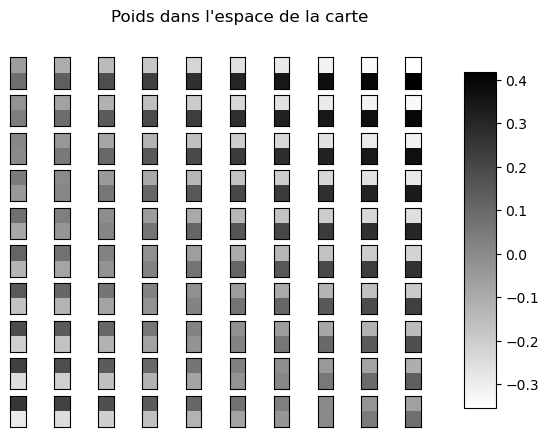

Sigma: 7.4
Erreur de quantification vectorielle moyenne: 0.2171364245491342
Distorsion locale moyenne: 0.003081109458020458
Rugosité locale moyenne: 0.003081109458020459


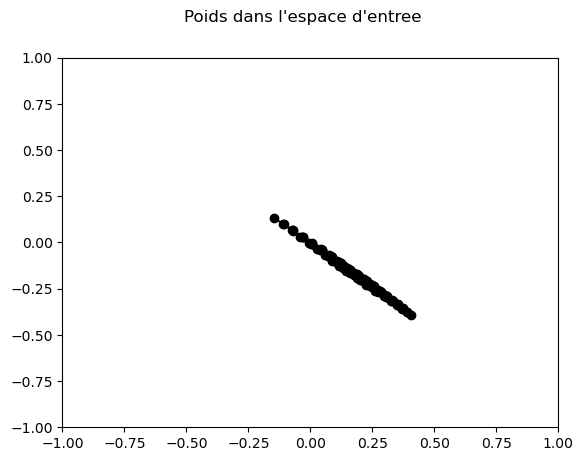

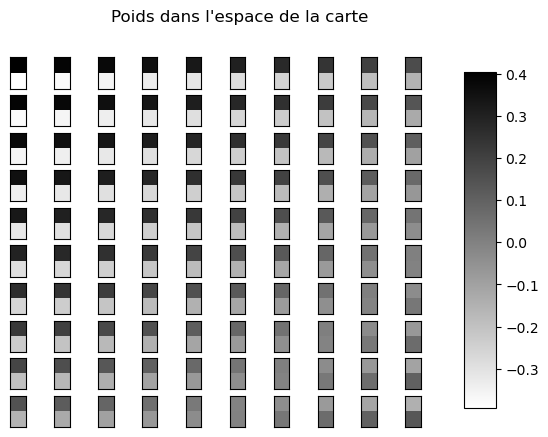

Sigma: 7.5
Erreur de quantification vectorielle moyenne: 0.2878649498276034
Distorsion locale moyenne: 0.0020369078154994303
Rugosité locale moyenne: 0.0020369078154994294


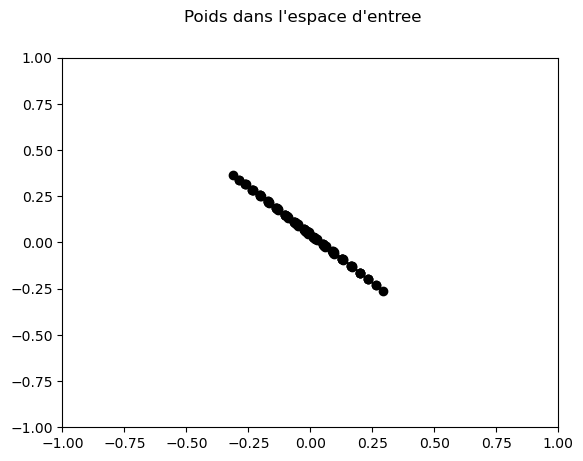

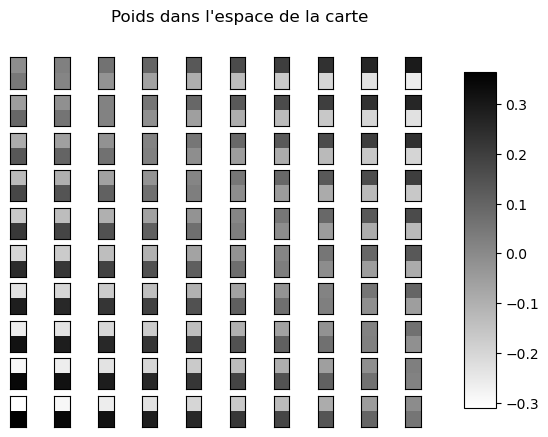

Sigma: 7.6
Erreur de quantification vectorielle moyenne: 0.22915288970615555
Distorsion locale moyenne: 0.002656540284168996
Rugosité locale moyenne: 0.0026565402841689997


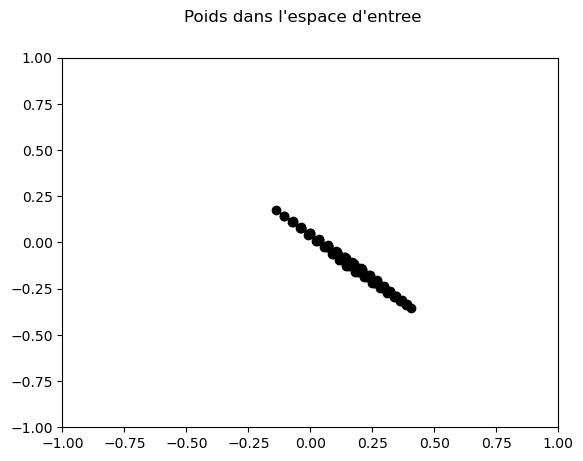

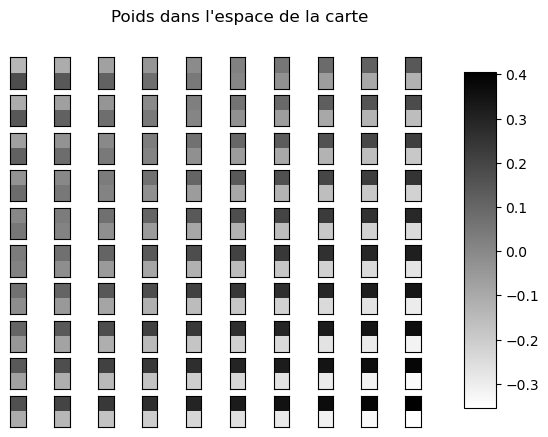

Sigma: 7.7
Erreur de quantification vectorielle moyenne: 0.2814437783214733
Distorsion locale moyenne: 0.001970441887435384
Rugosité locale moyenne: 0.0019704418874353846


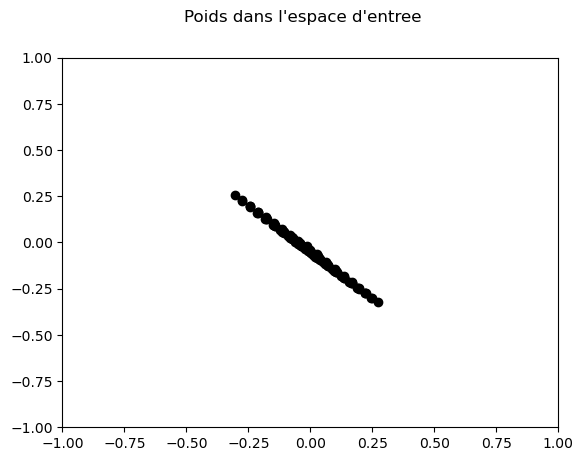

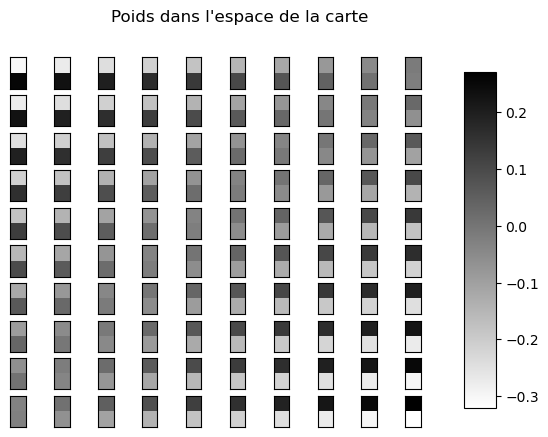

Sigma: 7.8
Erreur de quantification vectorielle moyenne: 0.2438545234972384
Distorsion locale moyenne: 0.002297799561068002
Rugosité locale moyenne: 0.002297799561068004


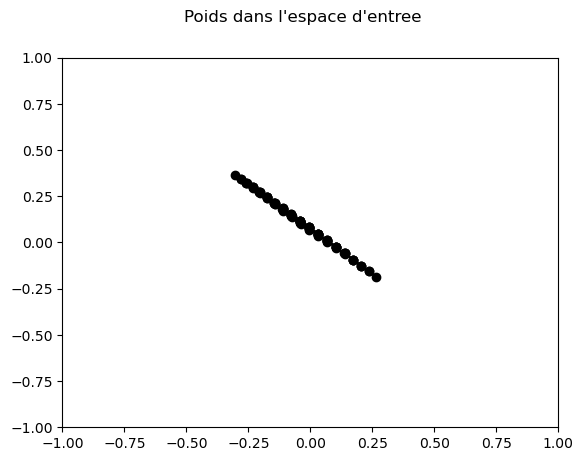

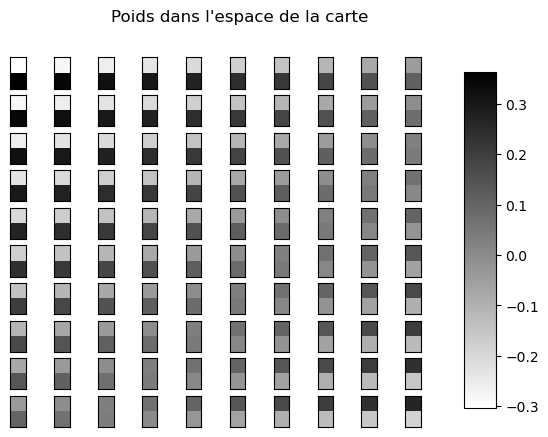

Sigma: 7.9
Erreur de quantification vectorielle moyenne: 0.2575835418003507
Distorsion locale moyenne: 0.0021707047961479803
Rugosité locale moyenne: 0.002170704796147981


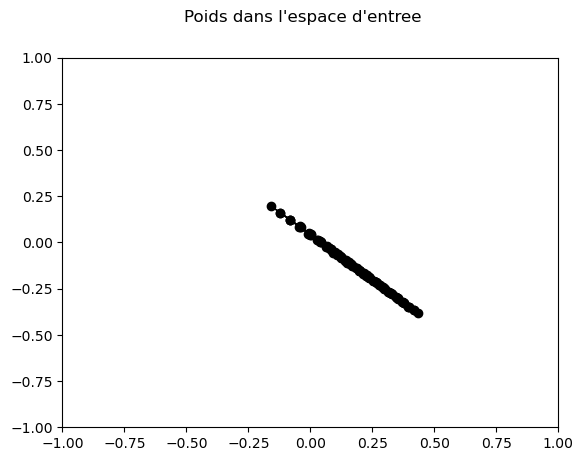

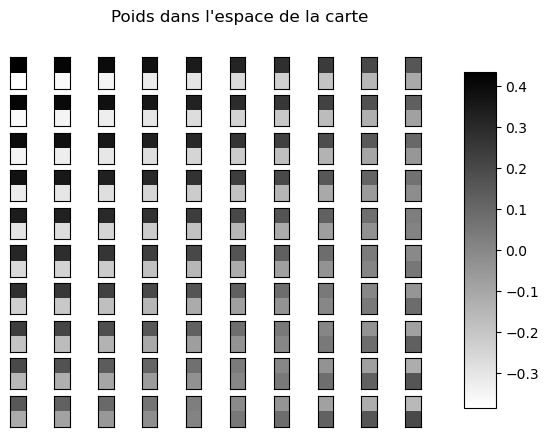

Sigma: 8.0
Erreur de quantification vectorielle moyenne: 0.25957787074351546
Distorsion locale moyenne: 0.002422539912885111
Rugosité locale moyenne: 0.002422539912885109


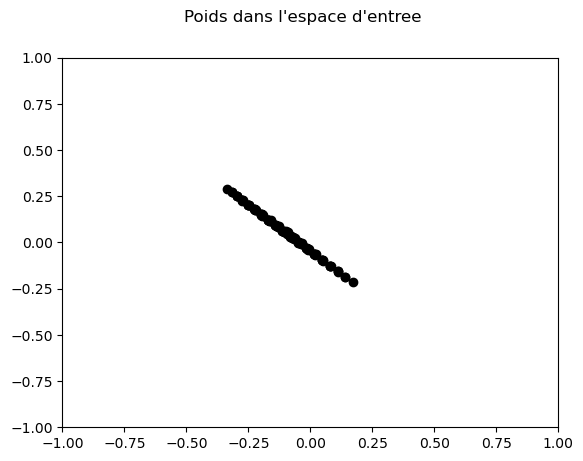

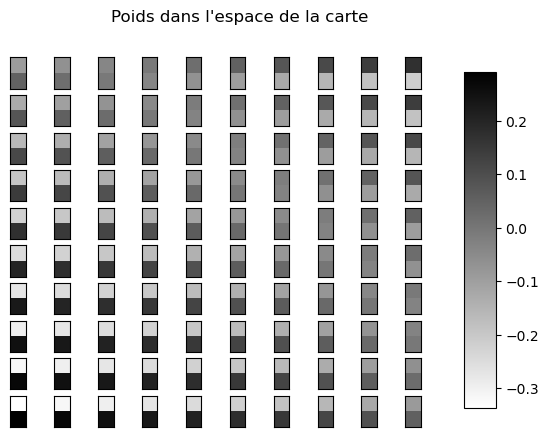

Sigma: 8.1
Erreur de quantification vectorielle moyenne: 0.2828300582635448
Distorsion locale moyenne: 0.0017418730414197343
Rugosité locale moyenne: 0.0017418730414197365


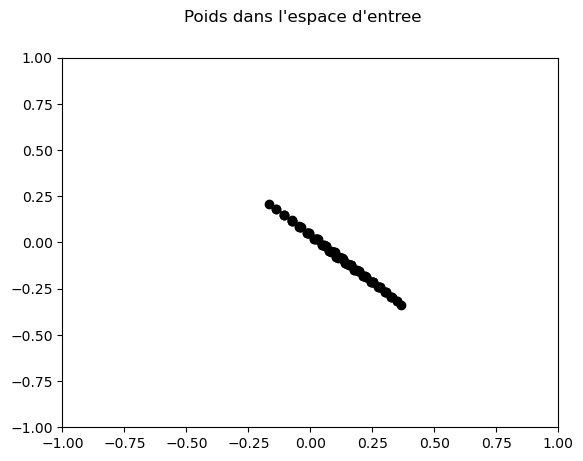

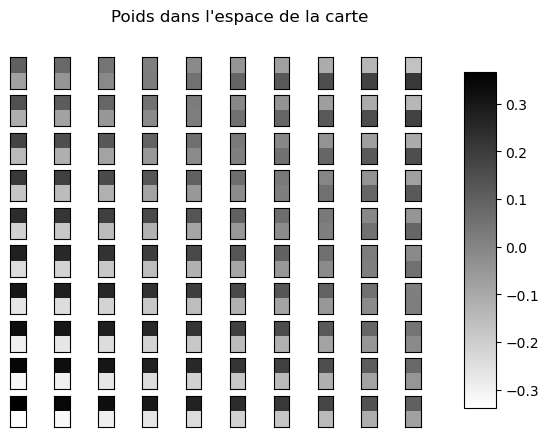

Sigma: 8.2
Erreur de quantification vectorielle moyenne: 0.2698271631387251
Distorsion locale moyenne: 0.0020146720723142135
Rugosité locale moyenne: 0.002014672072314213


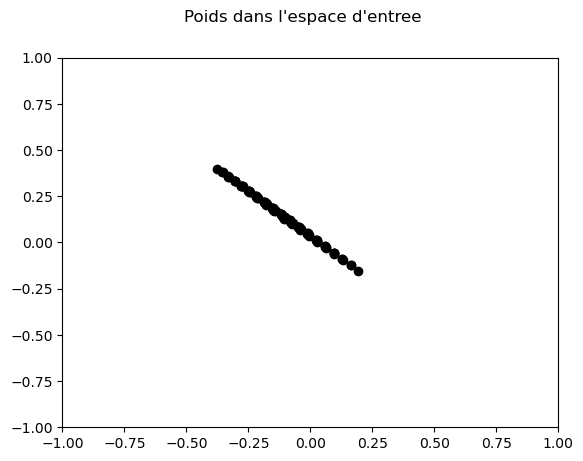

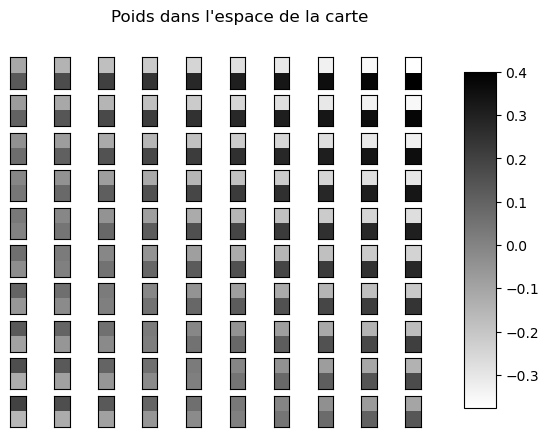

Sigma: 8.3
Erreur de quantification vectorielle moyenne: 0.2685755589244392
Distorsion locale moyenne: 0.0021583825360264987
Rugosité locale moyenne: 0.002158382536026501


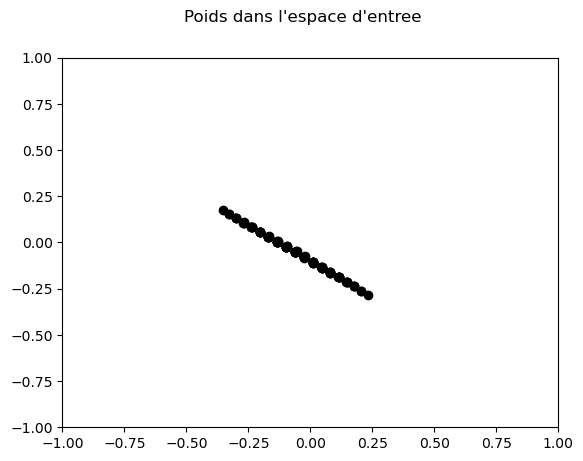

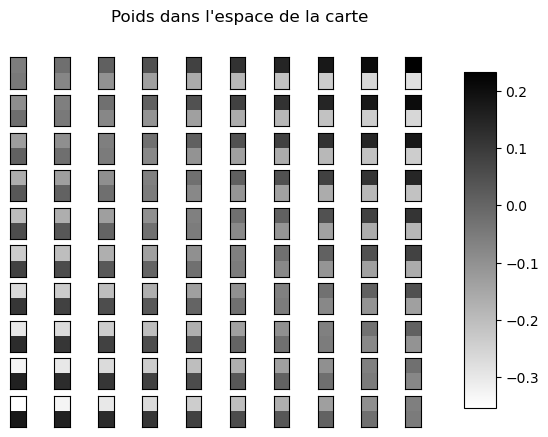

Sigma: 8.4
Erreur de quantification vectorielle moyenne: 0.27586157654146576
Distorsion locale moyenne: 0.0018751410245507706
Rugosité locale moyenne: 0.0018751410245507697


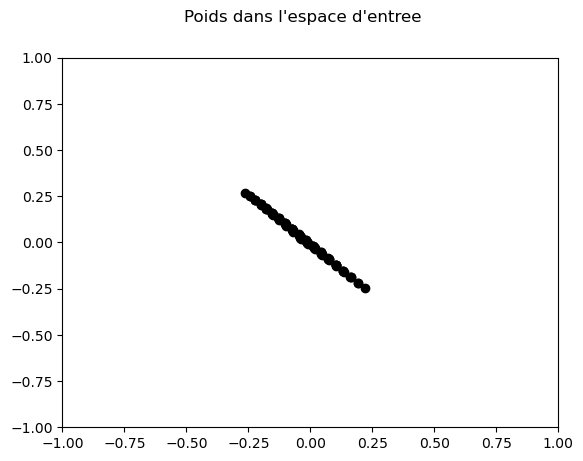

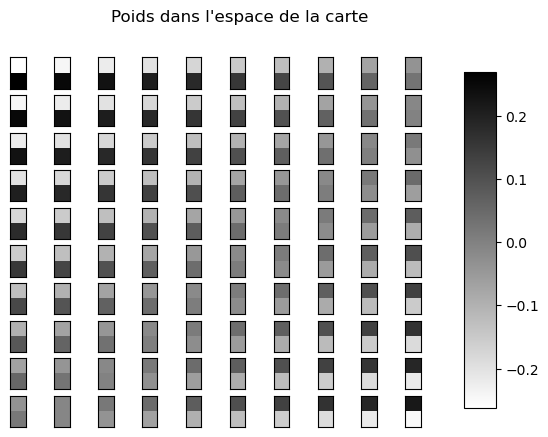

Sigma: 8.5
Erreur de quantification vectorielle moyenne: 0.27985554893953674
Distorsion locale moyenne: 0.0016785640752410849
Rugosité locale moyenne: 0.0016785640752410849


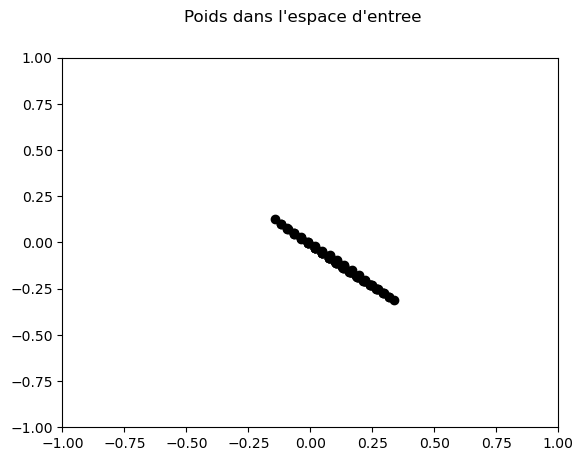

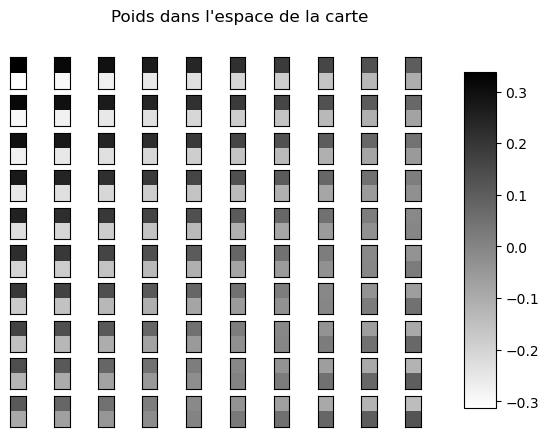

Sigma: 8.6
Erreur de quantification vectorielle moyenne: 0.3159082780093878
Distorsion locale moyenne: 0.0014030972651915246
Rugosité locale moyenne: 0.0014030972651915246


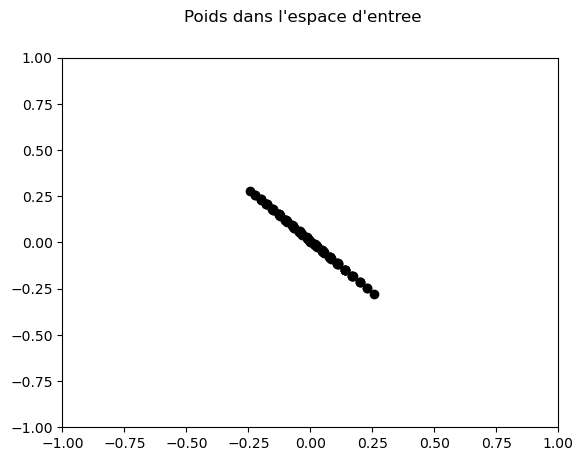

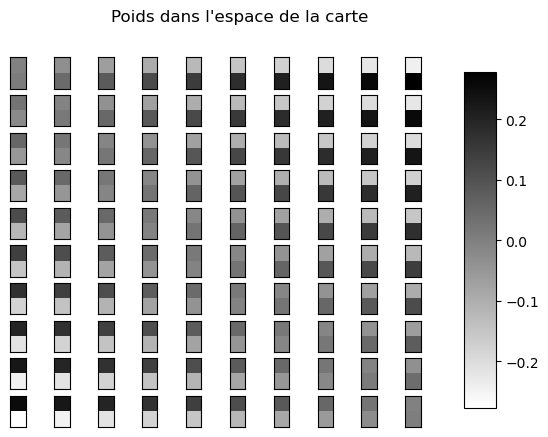

Sigma: 8.7
Erreur de quantification vectorielle moyenne: 0.26589115525096124
Distorsion locale moyenne: 0.0018659840200157356
Rugosité locale moyenne: 0.0018659840200157367


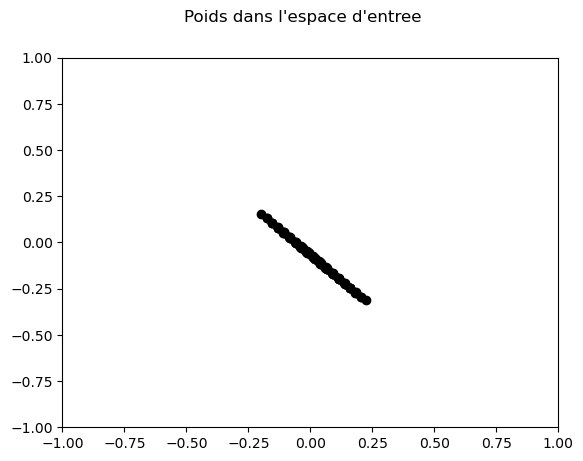

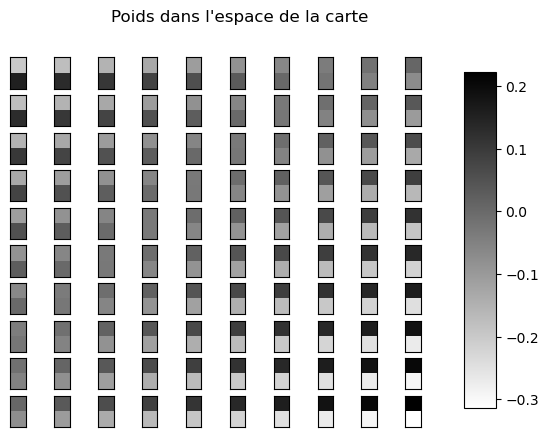

Sigma: 8.8
Erreur de quantification vectorielle moyenne: 0.314373328332138
Distorsion locale moyenne: 0.0013191886056356842
Rugosité locale moyenne: 0.001319188605635683


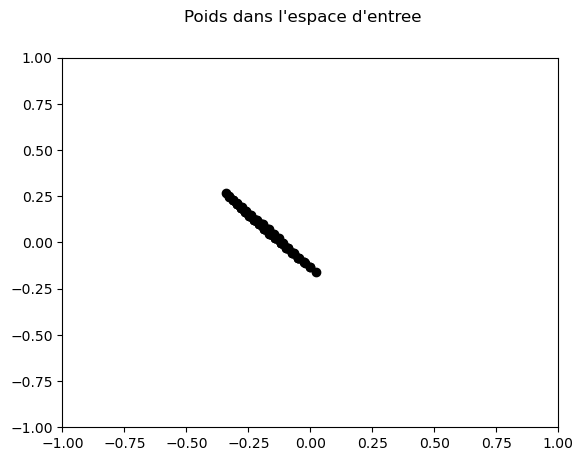

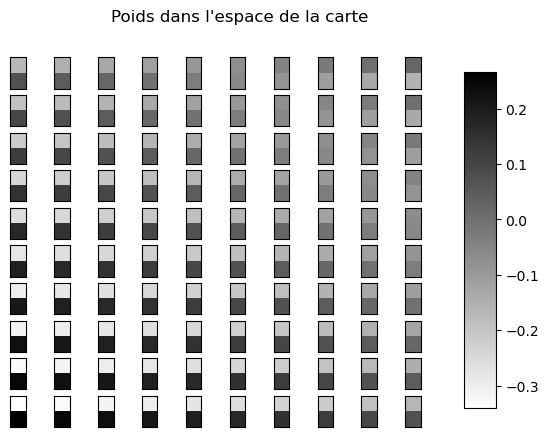

Sigma: 8.9
Erreur de quantification vectorielle moyenne: 0.36493072157808837
Distorsion locale moyenne: 0.0010327813050221093
Rugosité locale moyenne: 0.0010327813050221091


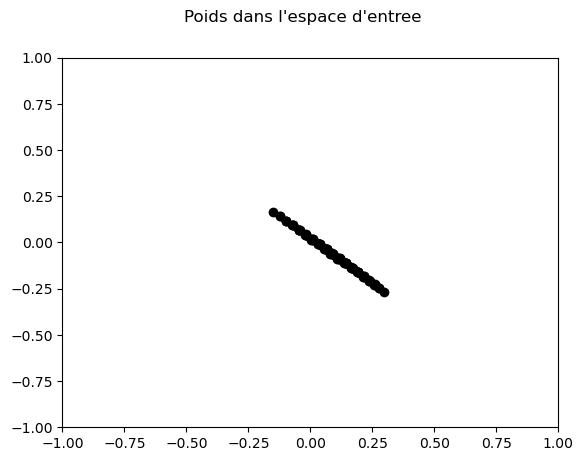

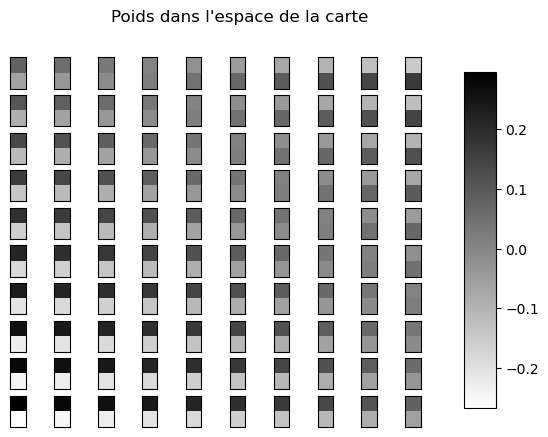

Sigma: 9.0
Erreur de quantification vectorielle moyenne: 0.31787468426073917
Distorsion locale moyenne: 0.001277635250156434
Rugosité locale moyenne: 0.0012776352501564345


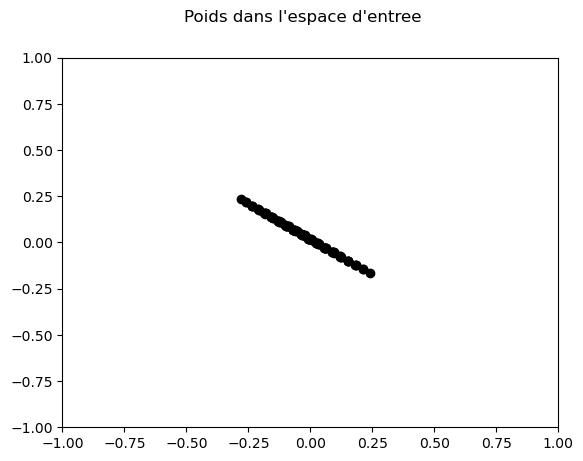

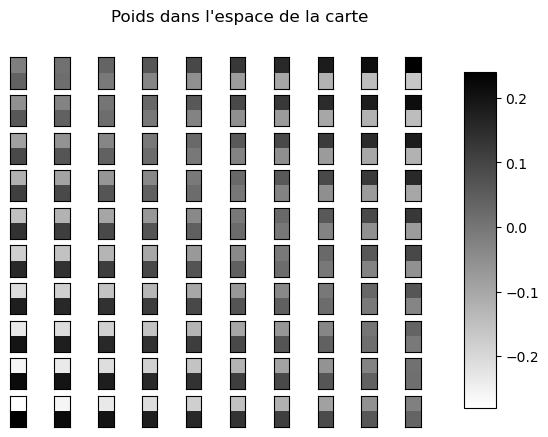

Sigma: 9.1
Erreur de quantification vectorielle moyenne: 0.3026120725360462
Distorsion locale moyenne: 0.0014332426833030556
Rugosité locale moyenne: 0.0014332426833030558


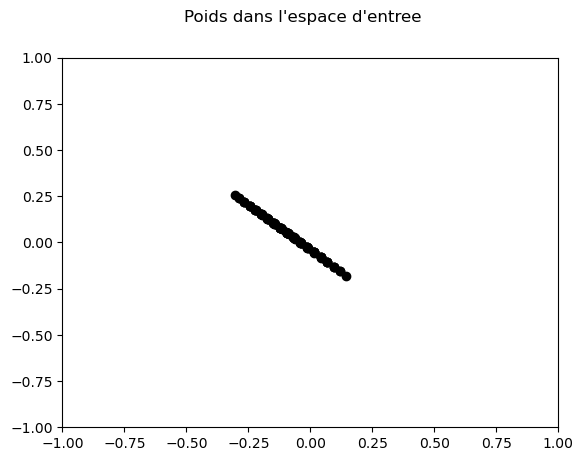

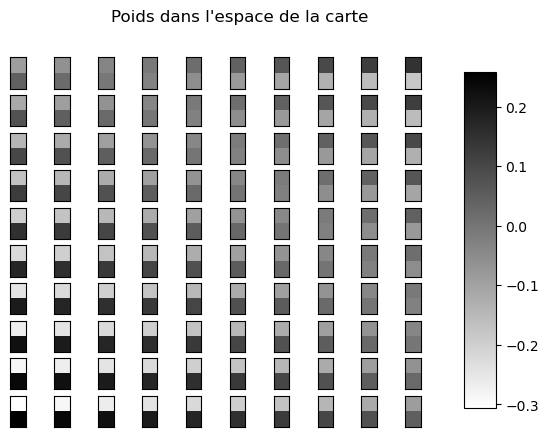

Sigma: 9.2
Erreur de quantification vectorielle moyenne: 0.315782587871905
Distorsion locale moyenne: 0.0013087851483246599
Rugosité locale moyenne: 0.001308785148324661


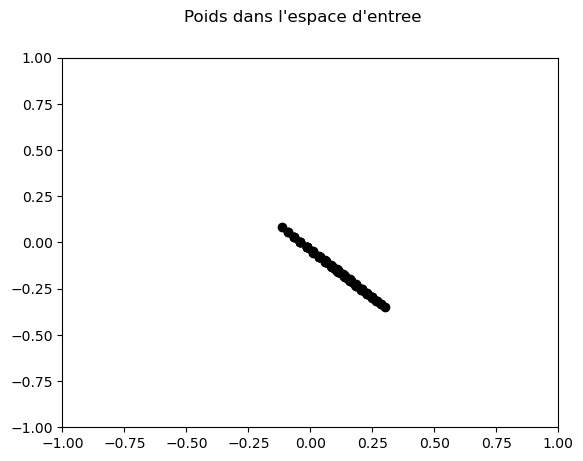

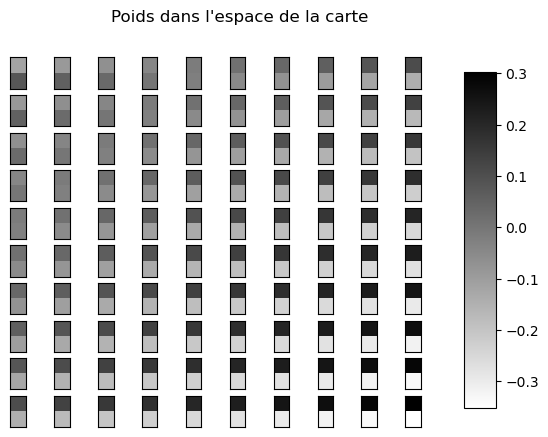

Sigma: 9.3
Erreur de quantification vectorielle moyenne: 0.3427609001225079
Distorsion locale moyenne: 0.0011936357461640238
Rugosité locale moyenne: 0.0011936357461640244


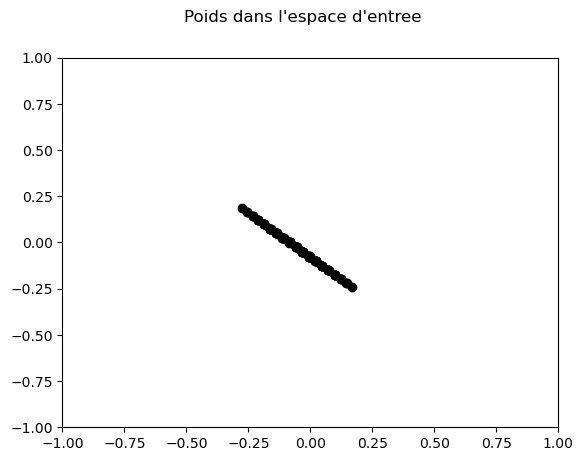

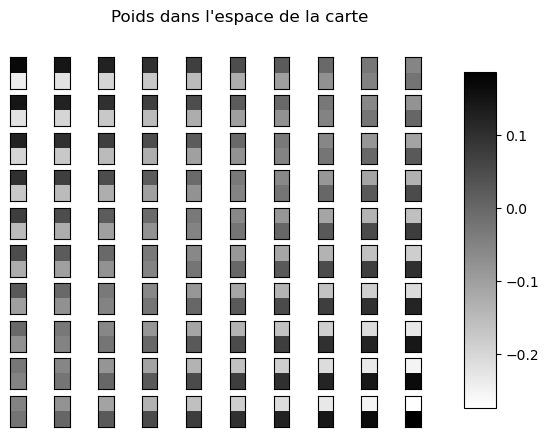

Sigma: 9.4
Erreur de quantification vectorielle moyenne: 0.3172715951753243
Distorsion locale moyenne: 0.0012474793396675568
Rugosité locale moyenne: 0.0012474793396675583


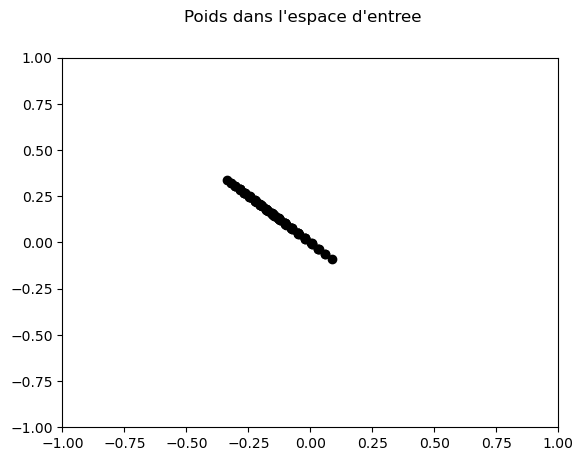

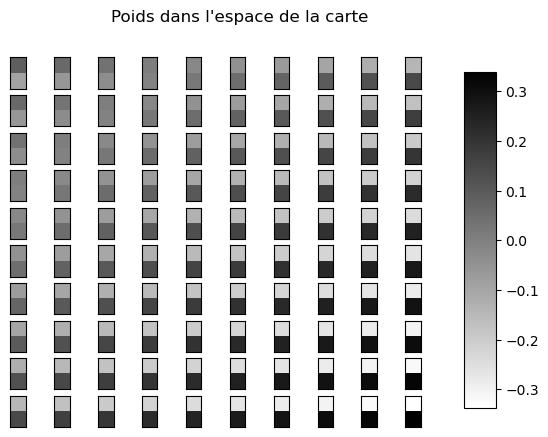

Sigma: 9.5
Erreur de quantification vectorielle moyenne: 0.347045369703323
Distorsion locale moyenne: 0.0011945333362175991
Rugosité locale moyenne: 0.0011945333362175998


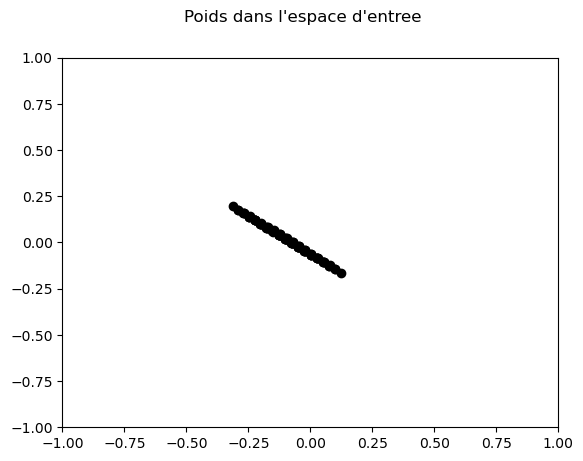

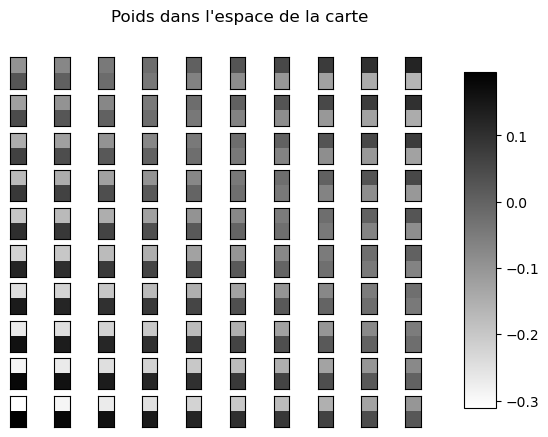

Sigma: 9.6
Erreur de quantification vectorielle moyenne: 0.3454077444066852
Distorsion locale moyenne: 0.0010319040640979563
Rugosité locale moyenne: 0.0010319040640979547


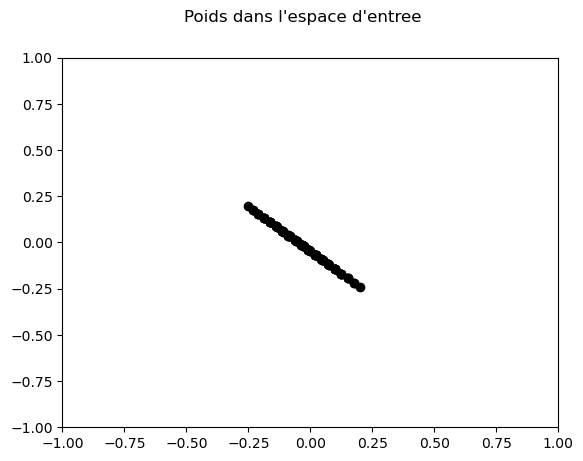

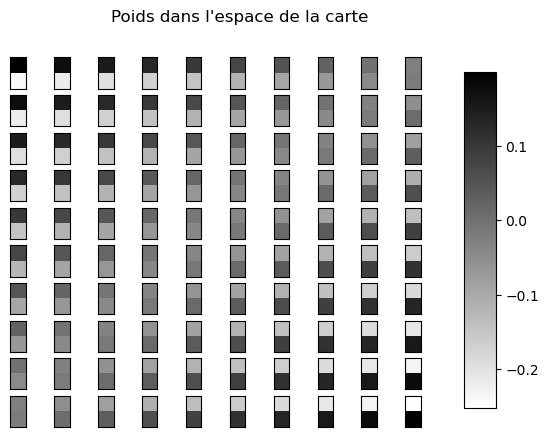

Sigma: 9.700000000000001
Erreur de quantification vectorielle moyenne: 0.3096337704149444
Distorsion locale moyenne: 0.0012944462537087165
Rugosité locale moyenne: 0.001294446253708715


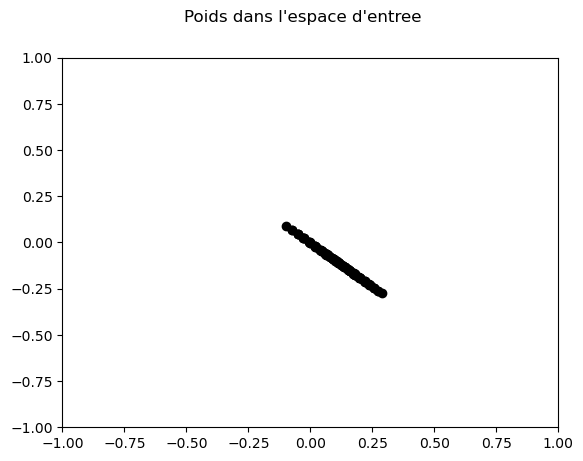

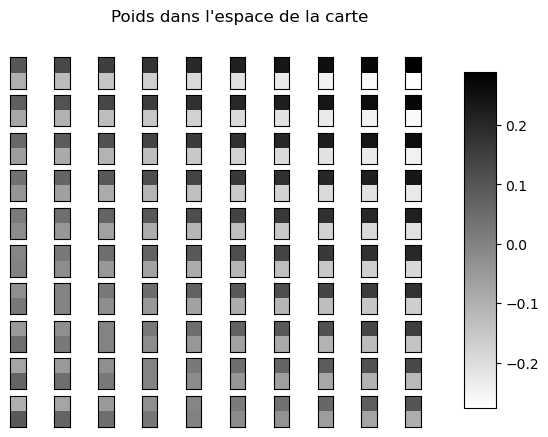

Sigma: 9.8
Erreur de quantification vectorielle moyenne: 0.3630231473524998
Distorsion locale moyenne: 0.0009353121633584177
Rugosité locale moyenne: 0.0009353121633584173


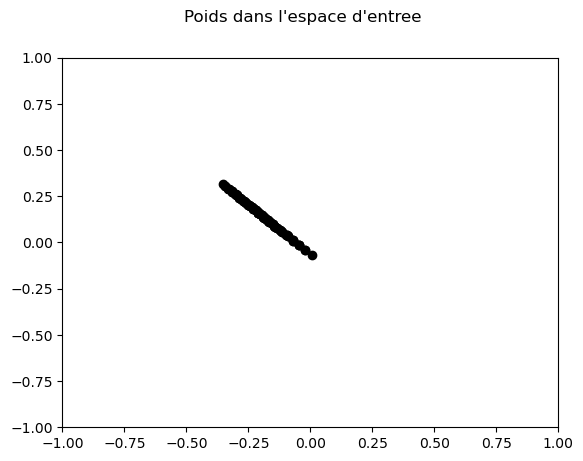

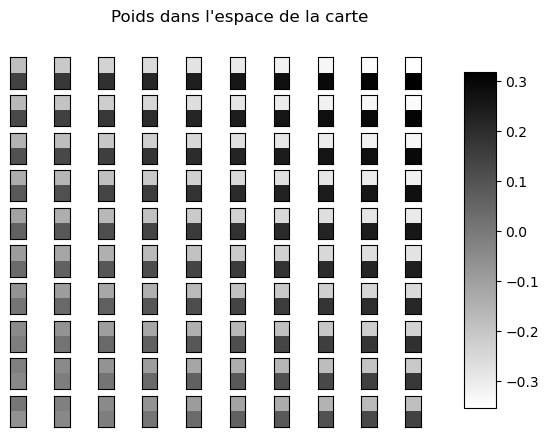

Sigma: 9.9
Erreur de quantification vectorielle moyenne: 0.39436211267718896
Distorsion locale moyenne: 0.000929224634664232
Rugosité locale moyenne: 0.0009292246346642322


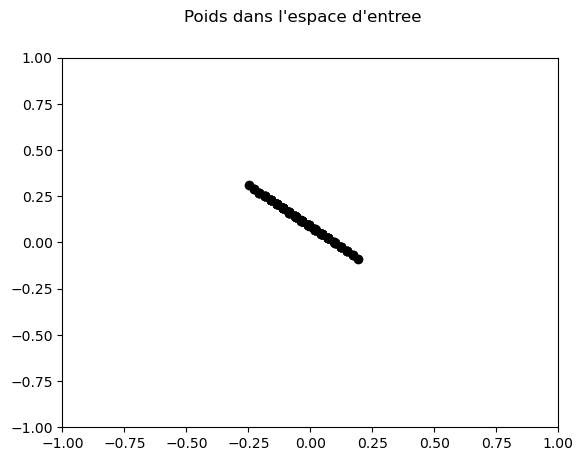

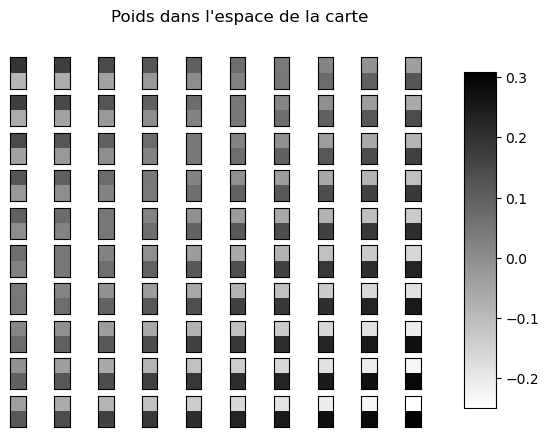

Sigma: 10.0
Erreur de quantification vectorielle moyenne: 0.3345179053020447
Distorsion locale moyenne: 0.001152766363183507
Rugosité locale moyenne: 0.0011527663631835062


ValueError: x and y must have same first dimension, but have shapes (91,) and (100,)

In [31]:
# Iterate over sigma values from 1 to 10 with an increment of 0.1
final_soms = {}
samples1 = numpy.random.random((nsamples//2,2,1))
samples1[:,0,:] -= 1
samples2 = numpy.random.random((nsamples//2,2,1))
samples2[:,1,:] -= 1
samples = numpy.concatenate((samples1,samples2))

# Create a directory to save the results
directory = "SOM_results"
if not os.path.exists(directory):
    os.makedirs(directory)

quantification_errors = []
compute_local_roughness_list = []
for sigma in numpy.arange(0.1, 10.1, 0.1):  # 10.1 to include 10
    # Create a new SOM for the current sigma
    som = SOM((2, 1), (10, 10))
    
    # Train the SOM
    for i in range(N + 1):
        index = numpy.random.randint(nsamples)
        x = samples[index].flatten()
        som.compute(x)
        som.learn(ETA, sigma, x)
    
    # Store the trained SOM
    final_soms[sigma] = som

    
    # Plot the final SOM
    som.scatter_plot(False)
    som.plot()
    print(f"Sigma: {sigma}")
    print("Erreur de quantification vectorielle moyenne:", som.quantification(samples))
    quantification_errors.append(som.quantification(samples))
    print("Distorsion locale moyenne:", distorsion_locale_moyenne(som))
    print("Rugosité locale moyenne:", compute_local_roughness(numpy.array(som.weightsmap)))
    compute_local_roughness_list.append(compute_local_roughness(numpy.array(som.weightsmap)))

# Plot quantification error and local roughness against sigma
plt.figure(figsize=(12, 6))

# Plot quantification error
plt.subplot(1, 2, 1)
plt.plot(numpy.arange(1, 10.1, 0.1), quantification_errors, label="Quantification Error", color="blue")
plt.xlabel("Sigma")
plt.ylabel("Quantification Error")
plt.title("Quantification Error vs Sigma")
plt.grid(True)
plt.legend()

# Plot local roughness
plt.subplot(1, 2, 2)
plt.plot(numpy.arange(1, 10.1, 0.1), compute_local_roughness_list, label="Local Roughness", color="red")
plt.xlabel("Sigma")
plt.ylabel("Local Roughness")
plt.title("Local Roughness vs Sigma")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Quantification Errors: [0.01141448 0.01182839 0.01147315 0.00569458 0.00541782 0.00543347
 0.00583713 0.00632674 0.00866148 0.00860643 0.00874026 0.01092359
 0.01148469 0.01557532 0.01542629 0.01487733 0.01805288 0.01906833
 0.02275078 0.02498254 0.02956566 0.03893704 0.03733526 0.04057854
 0.04872182 0.04696166 0.05445243 0.05101452 0.07014468 0.06204082
 0.05411555 0.06298652 0.07298259 0.07232579 0.06806722 0.08661103
 0.08735641 0.10360314 0.10191702 0.09950809 0.10482951 0.11491385
 0.10740264 0.10517252 0.11498026 0.12005    0.13620999 0.13143838
 0.14263507 0.13236521 0.1551487  0.14623978 0.14320474 0.16602084
 0.14158425 0.15558154 0.14831691 0.14982158 0.15882287 0.17677855
 0.17521126 0.17170386 0.16787935 0.19689748 0.17773444 0.17989956
 0.19643939 0.21302643 0.21685079 0.20680906 0.20642396 0.22251491
 0.25259971 0.21713642 0.28786495 0.22915289 0.28144378 0.24385452
 0.25758354 0.25957787 0.28283006 0.26982716 0.26857556 0.27586158
 0.27985555 0.31590828 0.26589116 0.314

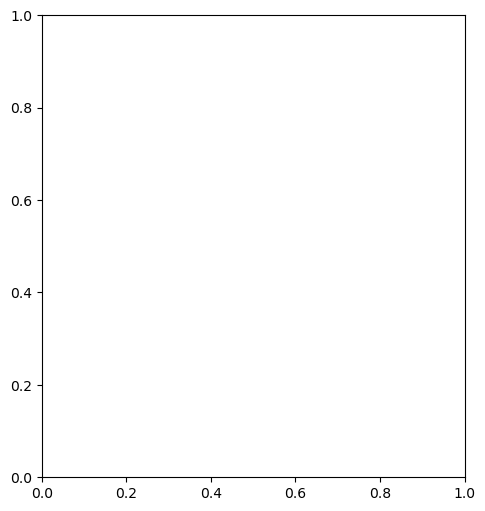

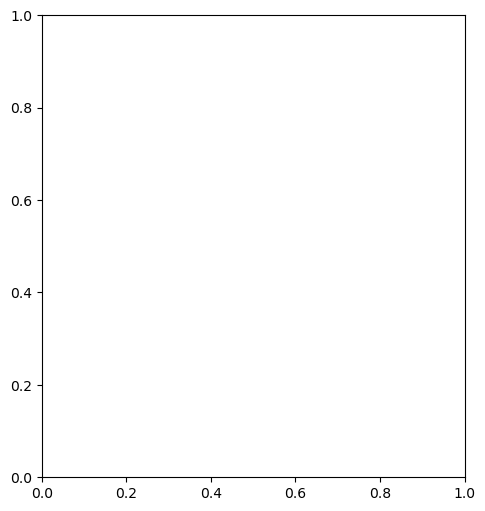

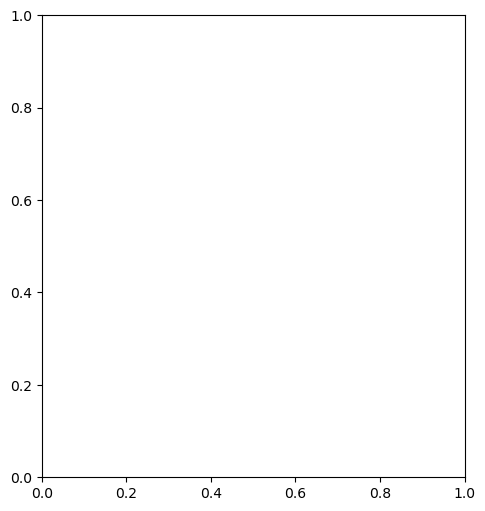

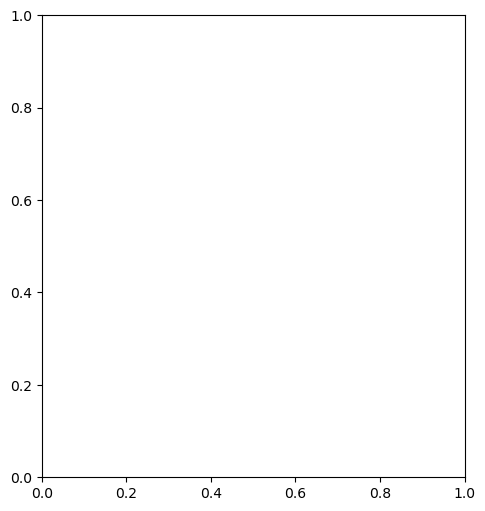

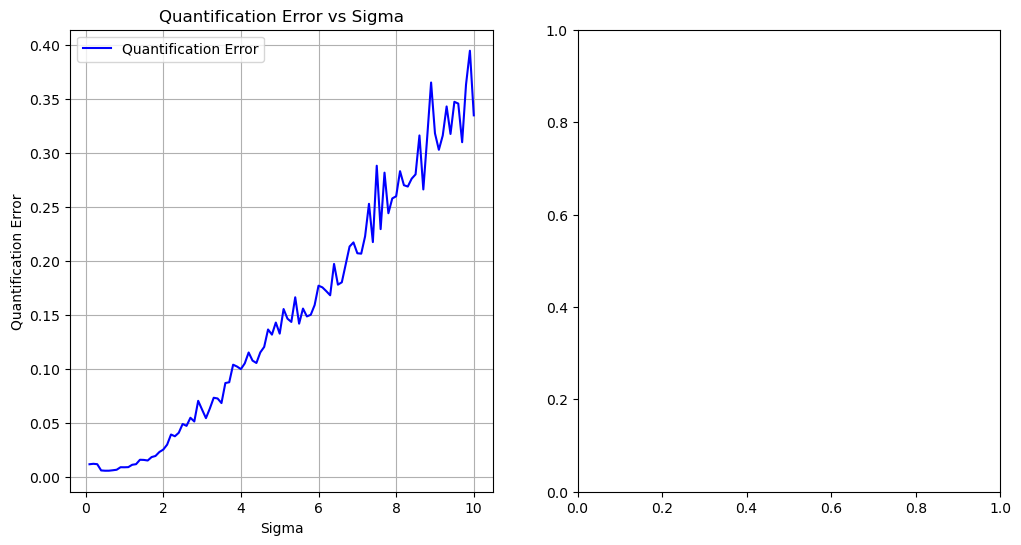

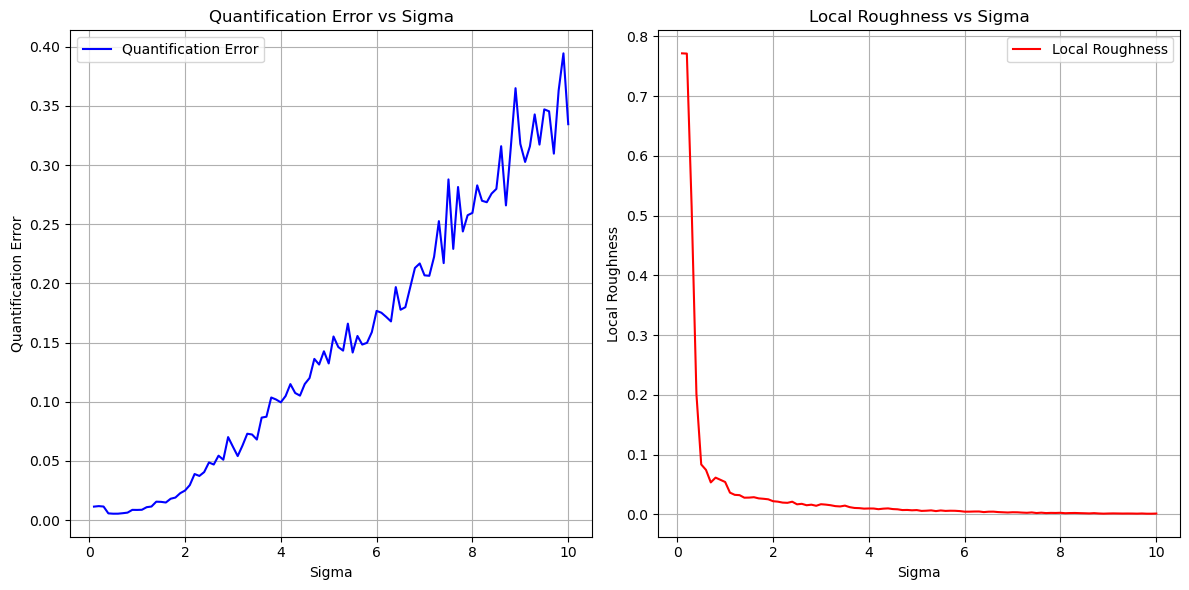

In [ ]:
print("Quantification Errors:", quantification_errors)
print("Local Roughness Values:", compute_local_roughness_list)
quantification_errors = numpy.array(quantification_errors)
compute_local_roughness_list = numpy.array(compute_local_roughness_list)
sigma_values = numpy.arange(0.1, 10.1, 0.1)

# Plot quantification error and local roughness against sigma
plt.figure(figsize=(12, 6))

# Plot quantification error
plt.subplot(1, 2, 1)
plt.plot(numpy.arange(0.1, 10.1, 0.1), quantification_errors, label="Quantification Error", color="blue")
plt.xlabel("Sigma")
plt.ylabel("Quantification Error")
plt.title("Quantification Error vs Sigma")
plt.grid(True)
plt.legend()

# Plot local roughness
plt.subplot(1, 2, 2)
plt.plot(numpy.arange(0.1, 10.1, 0.1), compute_local_roughness_list, label="Local Roughness", color="red")
plt.xlabel("Sigma")
plt.ylabel("Local Roughness")
plt.title("Local Roughness vs Sigma")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
# Save the results to a file
with open(os.path.join(directory, "resultats_etude_sigma.txt"), "w") as f:
    f.write("Sigma\tQuantification Error\tLocal Roughness\n")
    for sigma, quant_error, local_roughness in zip(numpy.arange(0.1, 10.1, 0.1), quantification_errors, compute_local_roughness_list):
        f.write(f"{sigma}\t{quant_error}\t{local_roughness}\n")